In [1]:
import os
import time
import absl.logging

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set ABSL logging to ERROR to suppress warnings (only show errors)
absl.logging.set_verbosity(absl.logging.ERROR)

In [2]:
# Necessary imports

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:

# Load the dataset
data = pd.read_csv("/Users/mandarangchekar/Downloads/ObesityDataSet_raw_and_data_sinthetic.csv", header=0)

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             2111 non-null   float64
 1   Gender                          2111 non-null   object 
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   CALC                            2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   SCC                             2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  family_history_with_overweight  2111 non-null   object 
 12  FAF                             21

In [4]:
print(data.head())  # Inspect the first few rows to understand what might be going wrong
print(data.dtypes) 

    Age  Gender  Height  Weight        CALC FAVC  FCVC  NCP  SCC SMOKE  CH2O  \
0  21.0  Female    1.62    64.0          no   no   2.0  3.0   no    no   2.0   
1  21.0  Female    1.52    56.0   Sometimes   no   3.0  3.0  yes   yes   3.0   
2  23.0    Male    1.80    77.0  Frequently   no   2.0  3.0   no    no   2.0   
3  27.0    Male    1.80    87.0  Frequently   no   3.0  3.0   no    no   2.0   
4  22.0    Male    1.78    89.8   Sometimes   no   2.0  1.0   no    no   2.0   

  family_history_with_overweight  FAF  TUE       CAEC                 MTRANS  \
0                            yes  0.0  1.0  Sometimes  Public_Transportation   
1                            yes  3.0  0.0  Sometimes  Public_Transportation   
2                            yes  2.0  1.0  Sometimes  Public_Transportation   
3                             no  2.0  0.0  Sometimes                Walking   
4                             no  0.0  0.0  Sometimes  Public_Transportation   

            NObeyesdad  
0        Norm

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Identify categorical and continuous columns
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
continuous_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

# Target column
target_col = 'NObeyesdad'

# Keep aside 100 data points from each class for testing
test_data = pd.concat([data.groupby(target_col, group_keys=False).apply(lambda x: x.sample(100))])
train_data = data.drop(test_data.index)

# Split the kept aside test data into features and target
X_test = test_data.drop(columns=[target_col])
y_test = test_data[target_col]

# Unbalance the training data
# Identify the class to augment or reduce
class_to_augment = 'Overweight_Level_II'  # Replace with the actual class you want to augment
# Separate the classes
class_data = train_data.groupby(target_col)
# Choose one class to duplicate points
class_to_augment_data = class_data.get_group(class_to_augment)
# Duplicate the chosen class data points
augmented_class_data = pd.concat([class_to_augment_data] * 3, ignore_index=True)
# Add noise to the duplicated points if continuous features are present
noise_factor = 0.03
noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=augmented_class_data[continuous_cols].shape)
augmented_class_data[continuous_cols] += noise
# Reassemble the training data
train_data = pd.concat([train_data, augmented_class_data]).sample(frac=1).reset_index(drop=True)  # Shuffle the data

# Randomly relabel 5% of the training data from each class
for class_name, group in train_data.groupby(target_col):
    num_to_relabel = int(0.08 * len(group))
    indices_to_relabel = np.random.choice(group.index, num_to_relabel, replace=False)
    current_labels = train_data.loc[indices_to_relabel, target_col]
    new_labels = [np.random.choice(train_data[target_col].unique()[train_data[target_col].unique() != current_label])
                  for current_label in current_labels]
    train_data.loc[indices_to_relabel, target_col] = new_labels

# Split the manipulated training data into features and target
X_train = train_data.drop(columns=[target_col])
y_train = train_data[target_col]

# Preprocess the data
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('cont', StandardScaler(), continuous_cols)
])
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
encoder = OneHotEncoder()

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).toarray()

# Output the shapes of the processed data
print(f"Transformed training features shape: {X_train_transformed.shape}")
print(f"Transformed test features shape: {X_test_transformed.shape}")
print(f"Encoded training labels shape: {y_train_encoded.shape}")
print(f"Encoded test labels shape: {y_test_encoded.shape}")


Transformed training features shape: (1981, 31)
Transformed test features shape: (700, 31)
Encoded training labels shape: (1981, 7)
Encoded test labels shape: (700, 7)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    Dense(64, input_dim=31, activation='relu'),  # Adjusted input dimension to 30
    Dense(64, activation='relu'),
    Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_transformed, y_train_encoded, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_transformed, y_test_encoded, verbose=0)
print(f"Test accuracy: {test_accuracy*100:.2f}%")


Epoch 1/50
50/50 [==============================] - 0s 2ms/step - loss: 1.6971 - accuracy: 0.3895 - val_loss: 1.4868 - val_accuracy: 0.4660
Epoch 2/50
50/50 [==============================] - 0s 541us/step - loss: 1.3104 - accuracy: 0.5543 - val_loss: 1.2162 - val_accuracy: 0.5919
Epoch 3/50
50/50 [==============================] - 0s 507us/step - loss: 1.0752 - accuracy: 0.6503 - val_loss: 1.0497 - val_accuracy: 0.6751
Epoch 4/50
50/50 [==============================] - 0s 499us/step - loss: 0.9389 - accuracy: 0.7279 - val_loss: 0.9581 - val_accuracy: 0.7003
Epoch 5/50
50/50 [==============================] - 0s 504us/step - loss: 0.8551 - accuracy: 0.7734 - val_loss: 0.8889 - val_accuracy: 0.7355
Epoch 6/50
50/50 [==============================] - 0s 505us/step - loss: 0.8046 - accuracy: 0.7967 - val_loss: 0.8548 - val_accuracy: 0.7456
Epoch 7/50
50/50 [==============================] - 0s 502us/step - loss: 0.7632 - accuracy: 0.8043 - val_loss: 0.8220 - val_accuracy: 0.7834
Epoch 8/

22/22 [==============================] - 0s 245us/step


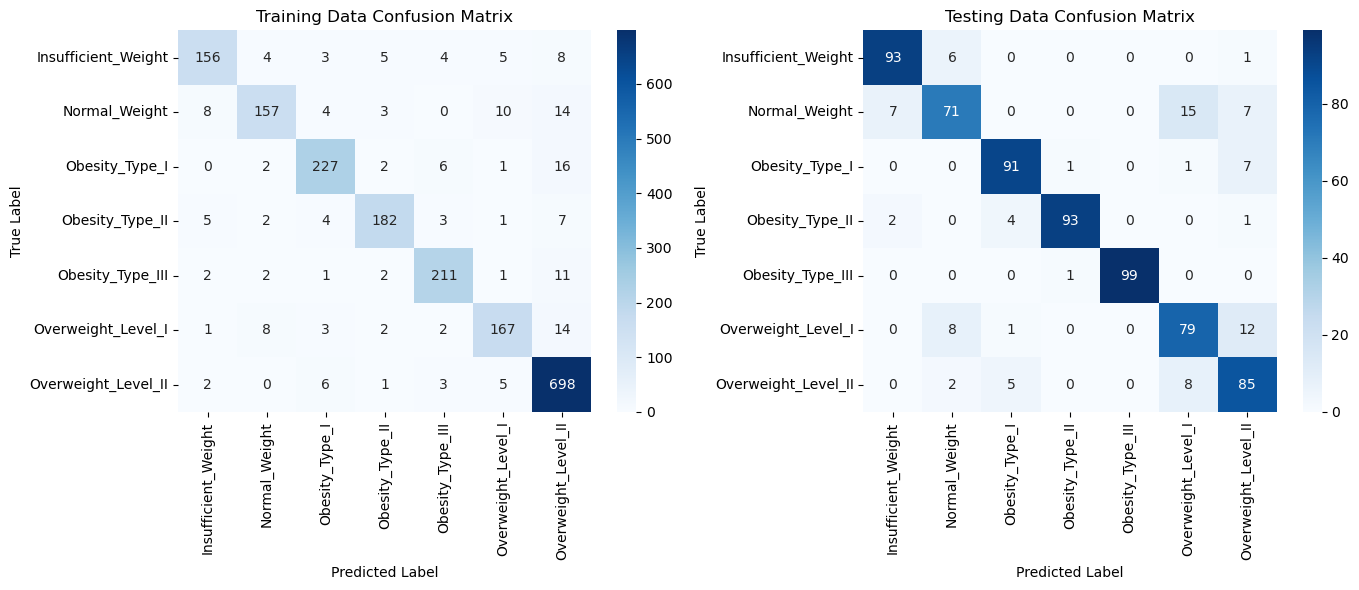

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the training and testing datasets
y_pred_train = model.predict(X_train_transformed)
y_pred_test = model.predict(X_test_transformed)

# Convert probabilities to class predictions
y_pred_train = np.argmax(y_pred_train, axis=1)
y_pred_test = np.argmax(y_pred_test, axis=1)

# Convert one-hot encoded y_train and y_test back to class indices for confusion matrix
y_train_classes = np.argmax(y_train_encoded, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)

# Compute the confusion matrices
cm_train = confusion_matrix(y_train_classes, y_pred_train)
cm_test = confusion_matrix(y_test_classes, y_pred_test)

# Plotting the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training Confusion Matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Training Data Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticklabels(encoder.categories_[0], rotation=90)
axes[0].set_yticklabels(encoder.categories_[0], rotation=0)

# Testing Confusion Matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Testing Data Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_xticklabels(encoder.categories_[0], rotation=90)
axes[1].set_yticklabels(encoder.categories_[0], rotation=0)

plt.tight_layout()
plt.show()


Initial best fitness: 0.8871


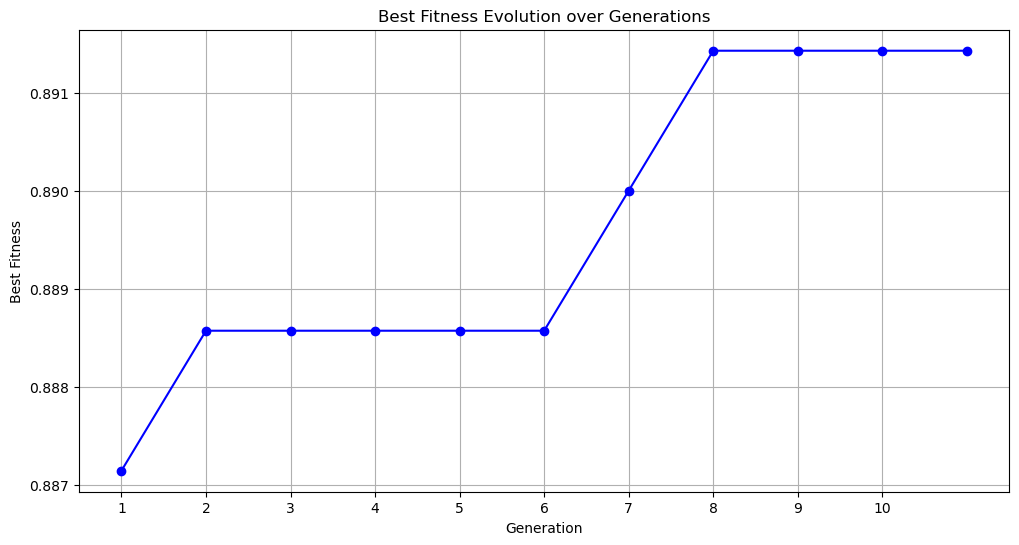

Total computational time: 614.69 seconds
Best Number of Neurons: 4029


In [8]:
# Basic Differential Evolution with higher bounds range

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
import numpy as np
import matplotlib.pyplot as plt

def fitness_function(num_neurons):
    tf.keras.backend.clear_session()
    num_neurons = int(num_neurons[0])

    # Define the neural network model
    model = Sequential([
        InputLayer(input_shape=(X_train_transformed.shape[1],)),
        Dense(num_neurons, activation='relu'),
        Dense(y_train_encoded.shape[1], activation='softmax')  # Output layer for multi-class
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train_transformed, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    
    # Evaluate the model
    _, accuracy = model.evaluate(X_test_transformed, y_test_encoded, verbose=0)
    return accuracy

def differential_evolution(fitness_func, bounds, max_gen, pop_size, F=0.1, CR=0.7):
    start_time = time.time()
    pop = np.random.rand(pop_size, len(bounds))
    pop_denorm = bounds[:, 0] + pop * (bounds[:, 1] - bounds[:, 0])
    fitness = np.asarray([fitness_func(ind) for ind in pop_denorm])
    best_idx = np.argmax(fitness)
    best = pop_denorm[best_idx]
    best_fitness_per_generation = [fitness[best_idx]]  # Initialize the list with the first generation's best fitness

    print(f"Initial best fitness: {fitness[best_idx]:.4f}")

    for gen in range(max_gen):
        for i in range(pop_size):
            idxs = [idx for idx in range(pop_size) if idx != i]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
            mutant = np.clip(a + F * (b - c), 0, 1)
            cross_points = np.random.rand(len(bounds)) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, len(bounds))] = True
            trial = np.where(cross_points, mutant, pop[i])
            trial_denorm = bounds[:, 0] + trial * (bounds[:, 1] - bounds[:, 0])
            trial_fitness = fitness_func(trial_denorm)
            
            if trial_fitness > fitness[i]:
                fitness[i] = trial_fitness
                pop[i] = trial
                if trial_fitness > fitness[best_idx]:
                    best_idx = i
                    best = trial_denorm
                    # No need to print each generation's best anymore, as we will plot it

        # At the end of each generation, append the current best fitness to the list
        best_fitness_per_generation.append(fitness[best_idx])

    # After all generations are complete, plot the best fitness evolution
    plt.figure(figsize=(12, 6))
    plt.plot(best_fitness_per_generation, marker='o', linestyle='-', color='blue')
    plt.title('Best Fitness Evolution over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.grid(True)
    plt.xticks(range(max_gen), range(1, max_gen + 1))
    plt.show()
    
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f"Total computational time: {elapsed_time:.2f} seconds") 

    return best

# Define bounds for the number of neurons in the hidden layer and other parameters
bounds = np.array([[5, 5000]])
max_gen = 10
pop_size = 100

# Run the Differential Evolution algorithm and print the best number of neurons found
best_hyperparams = differential_evolution(fitness_function, bounds, max_gen, pop_size)
print(f"Best Number of Neurons: {int(best_hyperparams[0])}")

22/22 [==============================] - 0s 401us/step


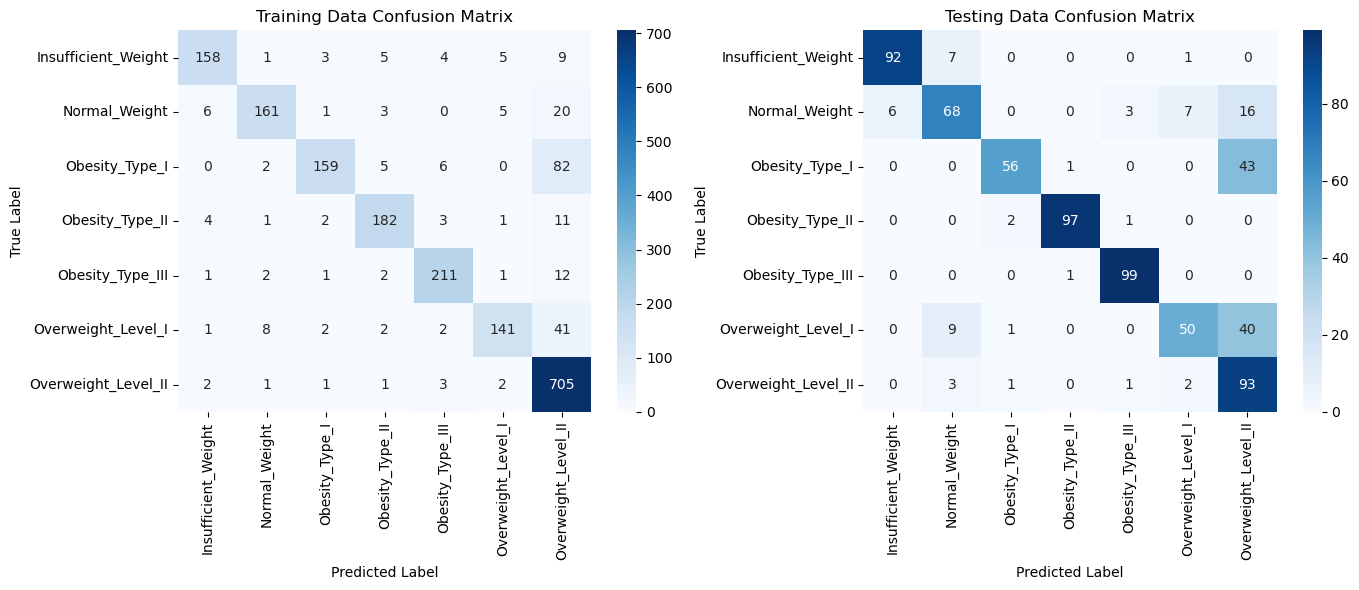

Best Number of Neurons: 4029


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the neural network model with the best number of neurons found
best_num_neurons = int(best_hyperparams[0])
model = Sequential([
    InputLayer(input_shape=(X_train_transformed.shape[1],)),
    Dense(best_num_neurons, activation='relu'),
    Dense(y_train_encoded.shape[1], activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_transformed, y_train_encoded, epochs=10, batch_size=32, verbose=0)

# Make predictions on the training and testing datasets
y_pred_train = model.predict(X_train_transformed)
y_pred_test = model.predict(X_test_transformed)

# Convert probabilities to class predictions
y_pred_train = np.argmax(y_pred_train, axis=1)
y_pred_test = np.argmax(y_pred_test, axis=1)

# Convert one-hot encoded y_train and y_test back to class indices for confusion matrix
y_train_classes = np.argmax(y_train_encoded, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)

# Compute the confusion matrices
cm_train = confusion_matrix(y_train_classes, y_pred_train)
cm_test = confusion_matrix(y_test_classes, y_pred_test)

# Plotting the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training Confusion Matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Training Data Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticklabels(encoder.categories_[0], rotation=90)
axes[0].set_yticklabels(encoder.categories_[0], rotation=0)

# Testing Confusion Matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Testing Data Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_xticklabels(encoder.categories_[0], rotation=90)
axes[1].set_yticklabels(encoder.categories_[0], rotation=0)

plt.tight_layout()
plt.show()

# Print the number of neurons found as the best
print(f"Best Number of Neurons: {best_num_neurons}")


Initial best fitness: 0.9171
Generation 1 - New best found: Individual 99 with 4 layers and neurons: [140. 247. 185. 114.], Fitness: 0.9200
Generation 2 - New best found: Individual 99 with 4 layers and neurons: [140. 247. 185. 114.], Fitness: 0.9200
Generation 3 - New best found: Individual 99 with 4 layers and neurons: [406. 171.  75. 142.], Fitness: 0.9271
Generation 4 - New best found: Individual 99 with 4 layers and neurons: [406. 171.  75. 142.], Fitness: 0.9271
Generation 5 - New best found: Individual 99 with 4 layers and neurons: [406. 171.  75. 142.], Fitness: 0.9271
Generation 6 - New best found: Individual 99 with 4 layers and neurons: [476. 340. 417. 433.], Fitness: 0.9300
Generation 7 - New best found: Individual 99 with 4 layers and neurons: [476. 340. 417. 433.], Fitness: 0.9300
Generation 8 - New best found: Individual 99 with 4 layers and neurons: [476. 340. 417. 433.], Fitness: 0.9300
Generation 9 - New best found: Individual 99 with 4 layers and neurons: [476. 340. 

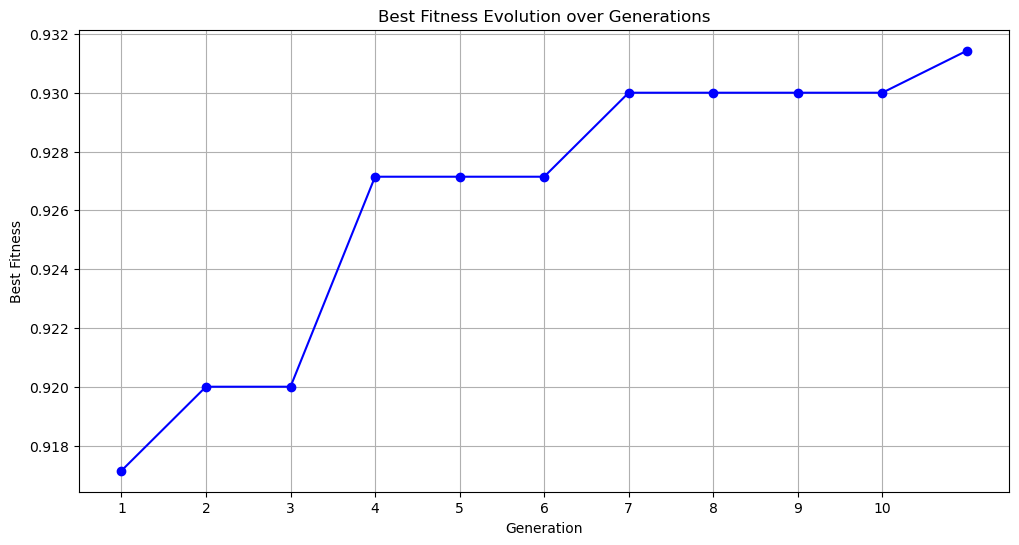

Total computational time: 819.02 seconds
Best architecture: 4 layers with neurons: [451. 125. 284. 249.]


In [10]:
# DE optimizing Number of Neurons as well as Number of hidden layers

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
import numpy as np

def fitness_function(params):
    tf.keras.backend.clear_session()
    num_layers = int(params[0])  # The first element is the number of layers
    layer_sizes = [int(size) for size in params[1:num_layers+1]]  # The subsequent elements are the layer sizes

    # Define the neural network model
    model = Sequential([InputLayer(input_shape=(X_train_transformed.shape[1],))])
    for size in layer_sizes:
        model.add(Dense(size, activation='relu'))
    model.add(Dense(y_train_encoded.shape[1], activation='softmax'))  # Output layer for multi-class

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train_transformed, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    
    # Evaluate the model
    _, accuracy = model.evaluate(X_test_transformed, y_test_encoded, verbose=0)
    return accuracy

def differential_evolution(fitness_func, bounds, max_gen, pop_size, F=0.1, CR=0.7):
    start_time = time.time()
    pop = np.random.rand(pop_size, len(bounds))
    pop_denorm = np.zeros_like(pop)
    best_fitness_per_generation = []  # Initialize the list to store best fitness per generation

    # Initialize and evaluate the initial population
    for i in range(pop_size):
        pop_denorm[i, 0] = int(bounds[0, 0] + pop[i, 0] * (bounds[0, 1] - bounds[0, 0]))  # Number of layers
        for j in range(1, int(pop_denorm[i, 0]) + 1):
            pop_denorm[i, j] = int(bounds[j, 0] + pop[i, j] * (bounds[j, 1] - bounds[j, 0]))  # Number of neurons in each layer

    fitness = np.asarray([fitness_func(ind) for ind in pop_denorm])
    best_idx = np.argmax(fitness)
    best = pop_denorm[best_idx]
    best_fitness_per_generation.append(fitness[best_idx])  # Store the best initial fitness
    print(f"Initial best fitness: {fitness[best_idx]:.4f}")

    for gen in range(max_gen):
        for i in range(pop_size):
            idxs = [idx for idx in range(pop_size) if idx != i]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
            mutant = np.clip(a + F * (b - c), 0, 1)
            cross_points = np.random.rand(len(bounds)) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, len(bounds))] = True
            trial = np.where(cross_points, mutant, pop[i])
            trial_denorm = trial.copy()
            trial_denorm[0] = int(bounds[0, 0] + trial[0] * (bounds[0, 1] - bounds[0, 0]))  # Number of layers
            for j in range(1, int(trial_denorm[0]) + 1):
                trial_denorm[j] = int(bounds[j, 0] + trial[j] * (bounds[j, 1] - bounds[j, 0]))  # Neurons
            trial_fitness = fitness_func(trial_denorm)
            
            if trial_fitness > fitness[i]:
                fitness[i] = trial_fitness
                pop[i] = trial
                if trial_fitness > fitness[best_idx]:
                    best_idx = i
                    best = trial_denorm
        best_fitness_per_generation.append(fitness[best_idx])  # Store the best fitness of the current generation

        print(f"Generation {gen+1} - New best found: Individual {i} with {int(best[0])} layers and neurons: {best[1:int(best[0])+1]}, Fitness: {fitness[best_idx]:.4f}")

    plt.figure(figsize=(12, 6))
    plt.plot(best_fitness_per_generation, marker='o', linestyle='-', color='blue')
    plt.title('Best Fitness Evolution over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.grid(True)
    plt.xticks(range(max_gen), range(1, max_gen + 1))
    plt.show()
    
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f"Total computational time: {elapsed_time:.2f} seconds") 

    return best

# Define bounds for the number of layers and neurons per layer
max_layers = 5
bounds = np.array([[1, max_layers]])  # Bounds for the number of layers
for _ in range(max_layers):
    bounds = np.vstack([bounds, [5, 500]])  # Bounds for the number of neurons in each layer

# Run the Differential Evolution algorithm
best_hyperparams = differential_evolution(fitness_function, bounds, max_gen=10, pop_size=100)
print(f"Best architecture: {int(best_hyperparams[0])} layers with neurons: {best_hyperparams[1:int(best_hyperparams[0])+1]}")


22/22 [==============================] - 0s 422us/step


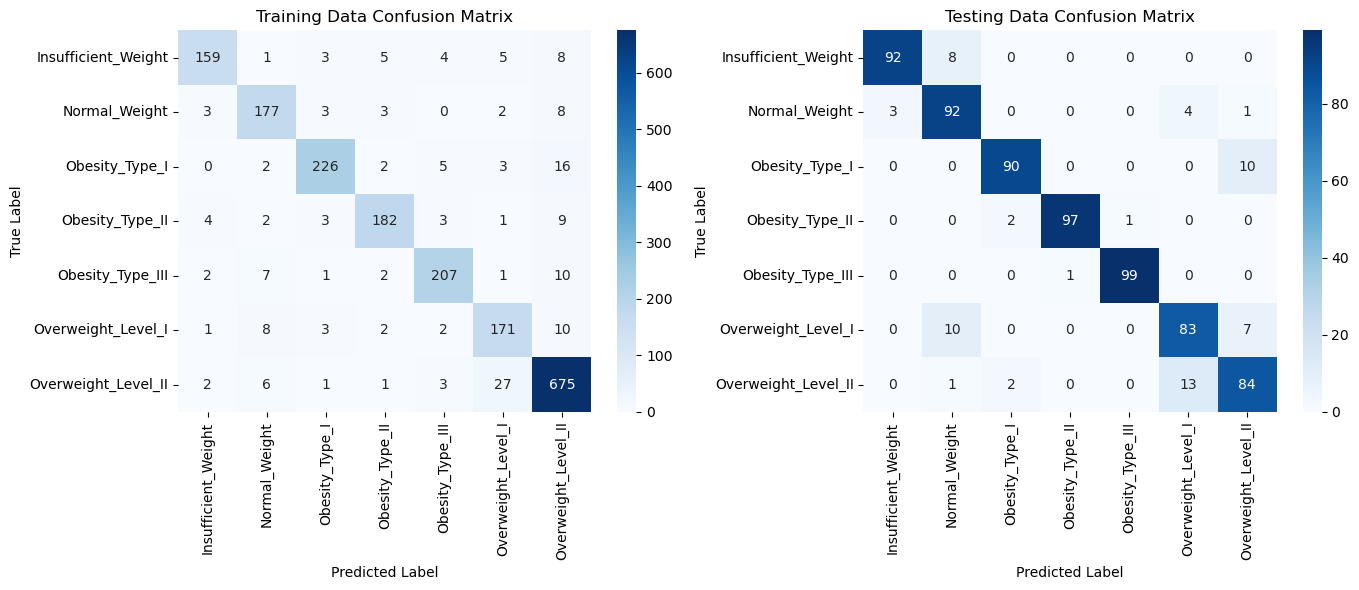

Optimized Architecture: 4 layers with neurons [451. 125. 284. 249.]


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder


# Define the neural network model with the optimized architecture
num_layers = int(best_hyperparams[0])  # Number of layers from DE
neurons_per_layer = best_hyperparams[1:num_layers+1]  # Neurons per layer from DE

model = Sequential([
    InputLayer(input_shape=(X_train_transformed.shape[1],))
])

# Adding the optimized hidden layers
for neurons in neurons_per_layer.astype(int):
    model.add(Dense(neurons, activation='relu'))

# Output layer
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_transformed, y_train_encoded, epochs=10, batch_size=32, verbose=0)

# Make predictions on the training and testing datasets
y_pred_train = model.predict(X_train_transformed)
y_pred_test = model.predict(X_test_transformed)

# Convert probabilities to class predictions
y_pred_train_classes = np.argmax(y_pred_train, axis=1)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Assuming y_train and y_test are pandas Series and contain categorical labels
encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).toarray()

# Convert one-hot encoded y_train and y_test back to class indices for confusion matrix
y_train_classes = np.argmax(y_train_encoded, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)

# Compute the confusion matrices
cm_train = confusion_matrix(y_train_classes, y_pred_train_classes)
cm_test = confusion_matrix(y_test_classes, y_pred_test_classes)

# Plotting the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training Confusion Matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Training Data Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticklabels(encoder.categories_[0].flatten(), rotation=90)
axes[0].set_yticklabels(encoder.categories_[0].flatten(), rotation=0)

# Testing Confusion Matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Testing Data Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_xticklabels(encoder.categories_[0].flatten(), rotation=90)
axes[1].set_yticklabels(encoder.categories_[0].flatten(), rotation=0)

plt.tight_layout()
plt.show()

# Print the optimized architecture
print(f"Optimized Architecture: {num_layers} layers with neurons {neurons_per_layer}")


Initial best fitness: 0.8843


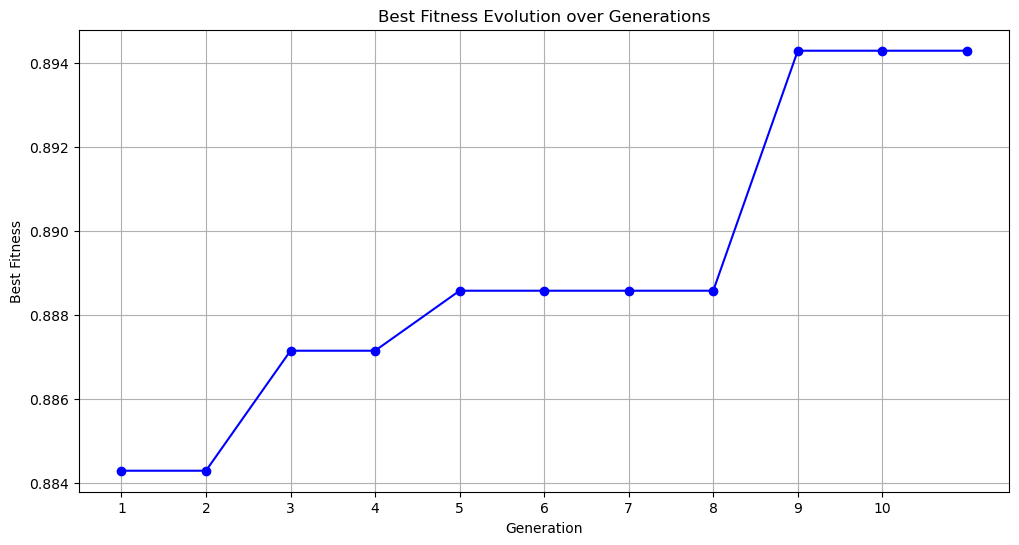

Total computational time: 772.73 seconds
Best Number of Neurons: 5000


In [12]:
# DE with considering individuals closer to the boundary and big range


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer

def fitness_function(num_neurons):
    tf.keras.backend.clear_session()
    num_neurons = int(num_neurons[0])

    model = Sequential([
        InputLayer(input_shape=(X_train_transformed.shape[1],)),
        Dense(num_neurons, activation='relu'),
        Dense(y_train_encoded.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train_transformed, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_test_transformed, y_test_encoded, verbose=0)
    
    return accuracy

def find_boundary_individual(population, a, bounds):
    a_norm = (a - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    pop_norm = (population - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    distance_to_boundary = np.min([pop_norm, 1 - pop_norm], axis=1)
    distance_to_a = np.linalg.norm(pop_norm - a_norm, axis=1)
    
    # Instead of summing distances, find the minimum across both distance metrics
    combined_distance = distance_to_boundary + distance_to_a
    
    # Find the index of the individual with the minimum combined distance
    boundary_individual_idx = np.argmin(combined_distance)
    
    # Return the actual individual from the population, not the distance
    return population[boundary_individual_idx]



def differential_evolution_modified(fitness_func, bounds, max_gen, pop_size, F=0.1, CR=0.7):
    start_time = time.time()
    pop = np.random.rand(pop_size, len(bounds))
    pop_denorm = bounds[:, 0] + pop * (bounds[:, 1] - bounds[:, 0])
    fitness = np.asarray([fitness_func(ind) for ind in pop_denorm])
    best_idx = np.argmax(fitness)
    best = pop_denorm[best_idx]
    best_fitness_per_generation = [fitness[best_idx]]  # Corrected variable name

    print(f"Initial best fitness: {fitness[best_idx]:.4f}")

    for gen in range(max_gen):
        for i in range(pop_size):
            idxs = [idx for idx in range(pop_size) if idx != i]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
            boundary_individual = find_boundary_individual(pop, a, bounds)
            mutant = np.clip(a + boundary_individual + F * (b - c), 0, 1)
            cross_points = np.random.rand(len(bounds)) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, len(bounds))] = True
                
            trial = np.where(cross_points, mutant, pop[i])
            trial_denorm = bounds[:, 0] + trial * (bounds[:, 1] - bounds[:, 0])
            f = fitness_func(trial_denorm)
            
            if f > fitness[i]:
                fitness[i] = f
                pop[i] = trial
                if f > fitness[best_idx]:
                    best_idx = i
                    best = trial_denorm
                    
        best_fitness_per_generation.append(fitness[best_idx])  # End of generation

    plt.figure(figsize=(12, 6))
    plt.plot(best_fitness_per_generation, marker='o', linestyle='-', color='blue')
    plt.title('Best Fitness Evolution over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.grid(True)
    plt.xticks(range(max_gen), range(1, max_gen + 1))
    plt.show()
    
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f"Total computational time: {elapsed_time:.2f} seconds") 
    
    return best


# Define bounds for the number of neurons in the hidden layer
bounds = np.array([[5, 5000]])  # Assuming a large range for neurons

# Run the Differential Evolution algorithm
best_hyperparams = differential_evolution_modified(fitness_function, bounds, max_gen=10, pop_size=100)
print(f"Best Number of Neurons: {int(best_hyperparams[0])}")


22/22 [==============================] - 0s 502us/step


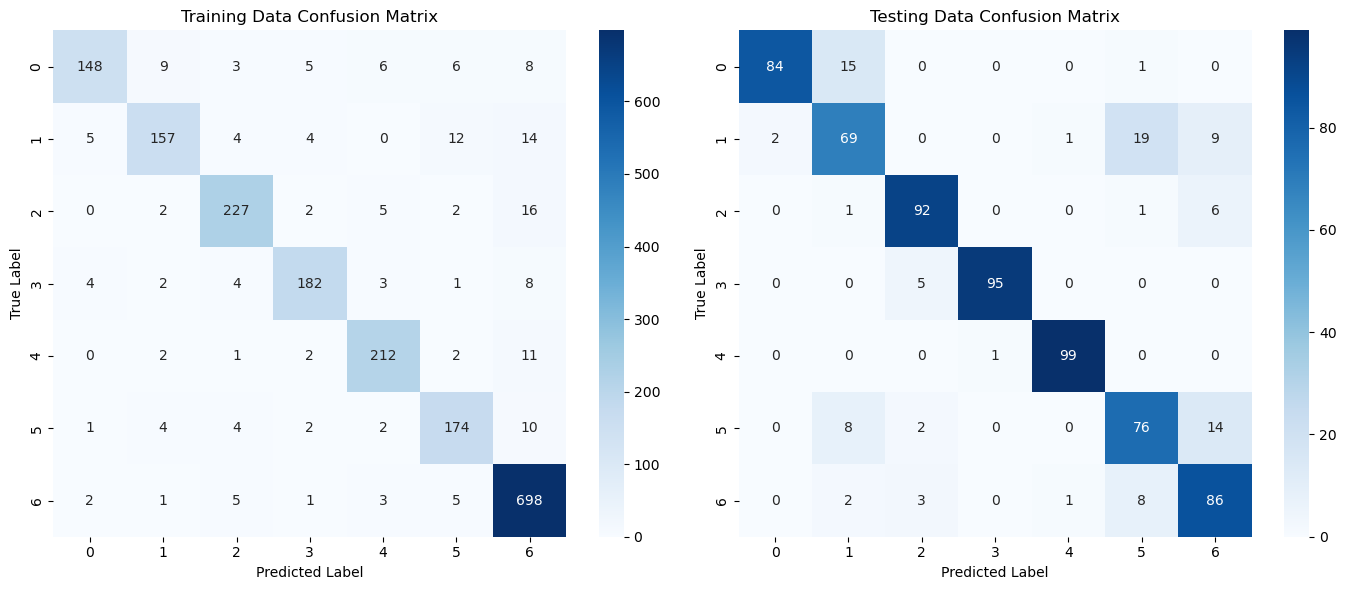

In [13]:

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Define the neural network model with the optimized number of neurons
best_num_neurons = int(best_hyperparams[0])
model = Sequential([
    InputLayer(input_shape=(X_train_transformed.shape[1],)),
    Dense(best_num_neurons, activation='relu'),
    Dense(y_train_encoded.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the training dataset
model.fit(X_train_transformed, y_train_encoded, epochs=10, batch_size=32, verbose=0)

# Predict with the trained model on the training dataset
y_pred_train = np.argmax(model.predict(X_train_transformed), axis=1)

# Predict with the trained model on the testing dataset
y_pred_test = np.argmax(model.predict(X_test_transformed), axis=1)

# Convert the one-hot encoded targets to class indices
y_train_classes = np.argmax(y_train_encoded, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)

# Compute the confusion matrix for the training dataset
cm_train = confusion_matrix(y_train_classes, y_pred_train)

# Compute the confusion matrix for the testing dataset
cm_test = confusion_matrix(y_test_classes, y_pred_test)

# Plot the confusion matrix for the training dataset
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Training Data Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Plot the confusion matrix for the testing dataset
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Testing Data Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()


Starting Differential Evolution...
Generation 1
Best fitness: 0.9257143139839172 with structure [  4.65369605  86.         150.          76.         419.        ]
Generation 2
Best fitness: 0.9257143139839172 with structure [  4.65369605  86.         150.          76.         419.        ]
Generation 3
Individual 99: Fitness 0.9128571152687073 with structure [  1.32124501 182.        ]
Best fitness: 0.9257143139839172 with structure [  4.65369605  86.         150.          76.         419.        ]
Generation 4
Individual 99: Fitness 0.9128571152687073 with structure [  2.17157224 441.         430.        ]
Best fitness: 0.9257143139839172 with structure [  4.65369605  86.         150.          76.         419.        ]
Generation 5
Individual 99: Fitness 0.9128571152687073 with structure [  2.31785116 189.         218.        ]
Best fitness: 0.9257143139839172 with structure [  4.65369605  86.         150.          76.         419.        ]
Generation 6
Best fitness: 0.927142858505249

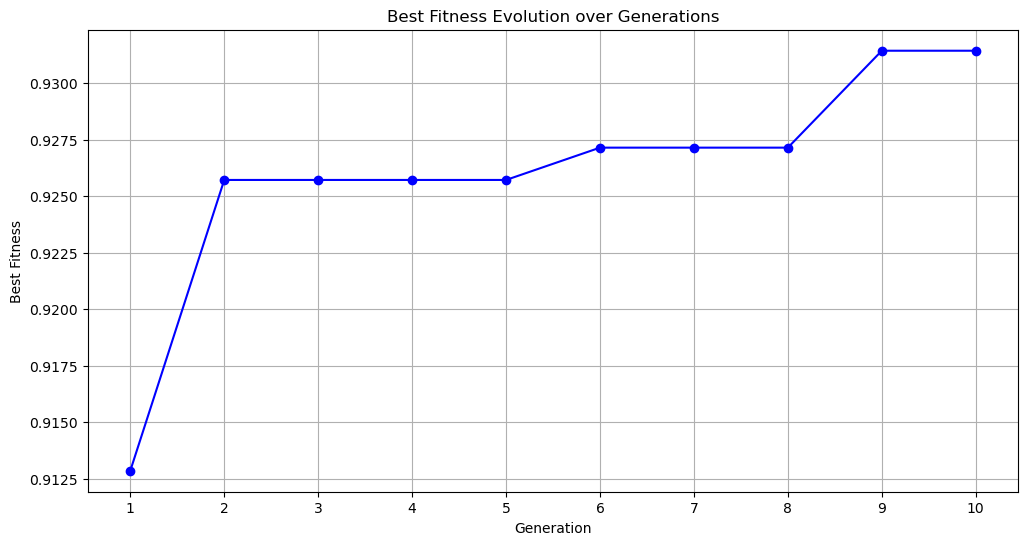

Total computational time: 958.42 seconds
Optimized architecture: 4 layers with neurons: [415. 264. 431. 177.]


In [14]:
# DE considering individuals closer to the boundary and optimizing both num of layers and neurons


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def fitness_function(layer_structure):
    tf.keras.backend.clear_session()
    num_layers = int(layer_structure[0])
    neurons_per_layer = [int(neurons) for neurons in layer_structure[1:num_layers+1]]

    model = Sequential([InputLayer(input_shape=(X_train_transformed.shape[1],))])
    for neurons in neurons_per_layer:
        model.add(Dense(neurons, activation='relu'))
    model.add(Dense(y_train_encoded.shape[1], activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_transformed, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_test_transformed, y_test_encoded, verbose=0)
    return accuracy


def find_boundary_individual(population, a, bounds):
    a_norm = (a - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    pop_norm = (population - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])

    # Find the distance of each individual component to the nearest boundary (0 or 1 in normalized space)
    distance_to_boundary = np.minimum(pop_norm, 1 - pop_norm)
    # Sum the distances for each individual to get their total distance to the nearest boundary
    total_distance_to_boundary = np.sum(distance_to_boundary, axis=1)
    
    # Calculate the Euclidean distance from each individual to the reference individual 'a'
    distance_to_a = np.linalg.norm(pop_norm - a_norm, axis=1)

    # Combine the two distances
    combined_distance = total_distance_to_boundary + distance_to_a
    # Find the index of the individual with the minimum combined distance
    boundary_individual_idx = np.argmin(combined_distance)
    
    # Return the actual individual from the population
    return population[boundary_individual_idx]


def differential_evolution_modified(fitness_func, bounds, max_gen, pop_size, F=0.1, CR=0.7):
    start_time = time.time()
    print("Starting Differential Evolution...")
    pop = np.random.rand(pop_size, bounds.shape[0])
    pop_denorm = np.empty_like(pop)
    best_fitness_per_generation = []  # List to store the best fitness per generation

    # Initialize population within bounds and convert to the correct types
    for i in range(pop_size):
        pop_denorm[i, 0] = np.random.uniform(bounds[0, 0], bounds[0, 1])  # Number of layers as int
        for j in range(1, bounds.shape[0]):
            pop_denorm[i, j] = np.random.uniform(bounds[j, 0], bounds[j, 1])  # Neurons as int
            
    fitness = np.asarray([fitness_func(individual[:int(individual[0])+1]) for individual in pop_denorm])
    best_idx = np.argmax(fitness)
    best = pop_denorm[best_idx]
    best_fitness_per_generation.append(fitness[best_idx])  # Append initial best fitness
        

    # Ensure that the number of neurons for unused layers is set to zero
    for individual in pop_denorm:
        num_layers = int(individual[0])
        individual[num_layers+1:] = 0
        individual[1:num_layers+1] = np.round(individual[1:num_layers+1]).astype(int)
    
    fitness = np.asarray([fitness_func(individual[:int(individual[0])+1]) for individual in pop_denorm])
    best_idx = np.argmax(fitness)
    best = pop_denorm[best_idx]
    
    for gen in range(max_gen):
        print(f"Generation {gen+1}")
        for i in range(pop_size):
            idxs = [idx for idx in range(pop_size) if idx != i]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
            boundary_individual = find_boundary_individual(pop, a, bounds)
            mutant = np.clip(a + F * (boundary_individual + b - c), 0, 1)
            cross_points = np.random.rand(bounds.shape[0]) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, bounds.shape[0])] = True

            trial = np.where(cross_points, mutant, pop[i])
            trial_denorm = trial.copy()
            trial_denorm[0] = np.random.uniform(bounds[0, 0], bounds[0, 1])
            for j in range(1, bounds.shape[0]):
                trial_denorm[j] = np.random.uniform(bounds[j, 0], bounds[j, 1])
            
            # Set neurons for unused layers to zero
            num_layers = int(trial_denorm[0])
            trial_denorm[num_layers+1:] = 0
            trial_denorm[1:num_layers+1] = np.round(trial_denorm[1:num_layers+1]).astype(int)
            
            f = fitness_func(trial_denorm[:num_layers+1])
            if f > fitness[i]:
                fitness[i] = f
                pop[i] = trial
            if f > fitness[best_idx]:
                best_idx = i
                best = trial_denorm
                best_fitness_per_generation.append(fitness[best_idx])  # Append new best fitness

        # Append the best fitness of the current generation in case no new best was found
        if len(best_fitness_per_generation) <= gen:
            best_fitness_per_generation.append(fitness[best_idx])
            print(f"Individual {i}: Fitness {fitness[i]} with structure {trial_denorm[:num_layers+1]}")
        print(f"Best fitness: {fitness[best_idx]} with structure {best[:int(best[0])+1]}")

    print(f"Final best solution: {best[:int(best[0])+1]} with fitness {fitness[best_idx]}")
    # Plot the best fitness over generations
    plt.figure(figsize=(12, 6))
    plt.plot(best_fitness_per_generation, marker='o', linestyle='-', color='blue')
    plt.title('Best Fitness Evolution over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.grid(True)
    plt.xticks(range(max_gen), range(1, max_gen + 1))
    plt.show()
    
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f"Total computational time: {elapsed_time:.2f} seconds") 

    return best[:int(best[0])+1]

# Define the bounds for the number of layers and neurons per layer
max_layers = 5
bounds = np.array([[1, max_layers]])  # Bounds for the number of layers
for _ in range(max_layers):
    bounds = np.vstack([bounds, [5, 500]])  # Bounds for the number of neurons in each layer

# Run the Differential Evolution algorithm
best_hyperparams = differential_evolution_modified(fitness_function, bounds, max_gen=10, pop_size=100)

print(f"Optimized architecture: {int(best_hyperparams[0])} layers with neurons: {best_hyperparams[1:int(best_hyperparams[0])+1]}")



22/22 [==============================] - 0s 793us/step


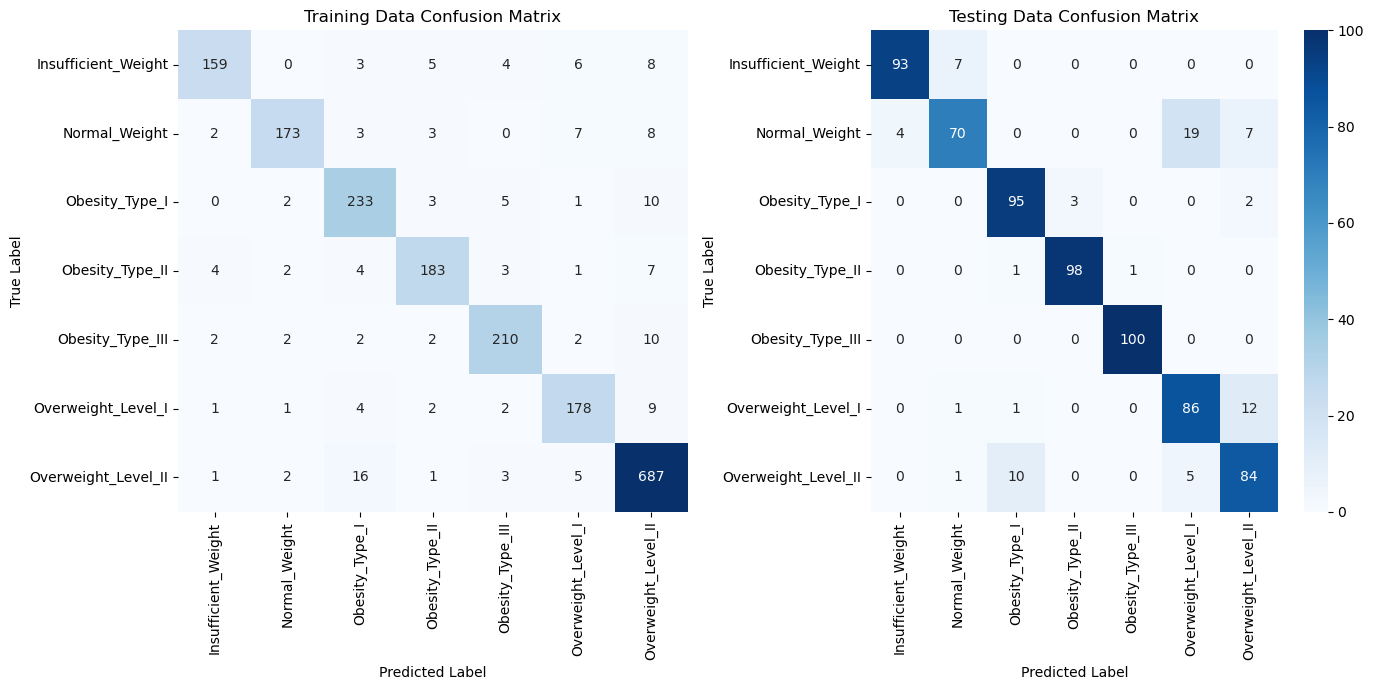

In [15]:
class_labels = encoder.categories_[0]
# Build and compile the model using the best_hyperparams
model = Sequential()
model.add(InputLayer(input_shape=(X_train_transformed.shape[1],)))
for i in range(int(best_hyperparams[0])):
    model.add(Dense(best_hyperparams[i+1], activation='relu'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_transformed, y_train_encoded, epochs=10, batch_size=32, verbose=0)

# Predictions for training and testing sets
y_pred_train = np.argmax(model.predict(X_train_transformed), axis=1)
y_pred_test = np.argmax(model.predict(X_test_transformed), axis=1)

# Convert one-hot encoded targets back to labels
y_true_train = np.argmax(y_train_encoded, axis=1)
y_true_test = np.argmax(y_test_encoded, axis=1)

# Confusion matrices
cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_test = confusion_matrix(y_true_test, y_pred_test)

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Training confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', ax=axes[0], cmap='Blues', cbar=False)
axes[0].set_title('Training Data Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticklabels(class_labels, rotation=90)
axes[0].set_yticklabels(class_labels, rotation=0)

# Testing confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', ax=axes[1], cmap='Blues', cbar=True)
axes[1].set_title('Testing Data Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_xticklabels(class_labels, rotation=90)
axes[1].set_yticklabels(class_labels, rotation=0)

plt.tight_layout()
plt.show()


Starting Differential Evolution...
Generation 1
Best fitness: 0.9285714030265808 with structure [  4.2936205 481.          8.        309.        334.       ]
Generation 2
Best fitness: 0.9285714030265808 with structure [  4.2936205 481.          8.        309.        334.       ]
Generation 3
Best fitness: 0.9285714030265808 with structure [  4.2936205 481.          8.        309.        334.       ]
Generation 4
Best fitness: 0.9285714030265808 with structure [  4.2936205 481.          8.        309.        334.       ]
Generation 5
Best fitness: 0.9285714030265808 with structure [  4.2936205 481.          8.        309.        334.       ]
Generation 6
Best fitness: 0.9285714030265808 with structure [  4.2936205 481.          8.        309.        334.       ]
Generation 7
Best fitness: 0.9285714030265808 with structure [  4.2936205 481.          8.        309.        334.       ]
Generation 8
Best fitness: 0.9285714030265808 with structure [  4.2936205 481.          8.        309.  

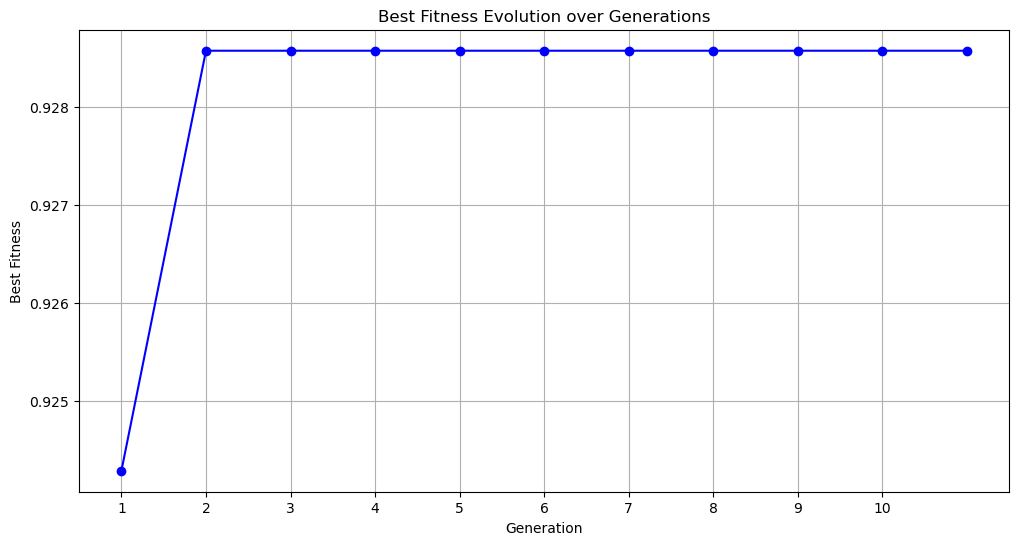

Total computational time: 964.20 seconds
Optimized architecture: 4 layers with neurons: [481.   8. 309. 334.]


In [16]:
# DE with probabilistic mutation optimizing both num of neurons and num of layers

def fitness_function(layer_structure):
    tf.keras.backend.clear_session()
    num_layers = int(layer_structure[0])
    neurons_per_layer = [int(neurons) for neurons in layer_structure[1:num_layers+1]]

    model = Sequential([InputLayer(input_shape=(X_train_transformed.shape[1],))])
    for neurons in neurons_per_layer:
        model.add(Dense(neurons, activation='relu'))
    model.add(Dense(y_train_encoded.shape[1], activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_transformed, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_test_transformed, y_test_encoded, verbose=0)
    return accuracy


def find_boundary_individual(population, a, bounds):
    a_norm = (a - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    pop_norm = (population - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])

    # Find the distance of each individual component to the nearest boundary (0 or 1 in normalized space)
    distance_to_boundary = np.minimum(pop_norm, 1 - pop_norm)
    # Sum the distances for each individual to get their total distance to the nearest boundary
    total_distance_to_boundary = np.sum(distance_to_boundary, axis=1)
    
    # Calculate the Euclidean distance from each individual to the reference individual 'a'
    distance_to_a = np.linalg.norm(pop_norm - a_norm, axis=1)

    # Combine the two distances
    combined_distance = total_distance_to_boundary + distance_to_a
    # Find the index of the individual with the minimum combined distance
    boundary_individual_idx = np.argmin(combined_distance)
    
    # Return the actual individual from the population
    return population[boundary_individual_idx]

def differential_evolution_modified(fitness_func, bounds, max_gen, pop_size, F=0.1, CR=0.7):
    start_time = time.time()
    print("Starting Differential Evolution...")
    pop = np.random.rand(pop_size, bounds.shape[0])
    pop_denorm = np.empty_like(pop)
    best_fitness_per_generation = []  # List to store the best fitness per generation

    # Initialize population within bounds and convert to the correct types
    for i in range(pop_size):
        pop_denorm[i, 0] = np.random.uniform(bounds[0, 0], bounds[0, 1])  # Number of layers as int
        for j in range(1, bounds.shape[0]):
            pop_denorm[i, j] = np.random.uniform(bounds[j, 0], bounds[j, 1])  # Neurons as int
            
    
    fitness = np.asarray([fitness_func(individual[:int(individual[0])+1]) for individual in pop_denorm])
    best_idx = np.argmax(fitness)
    best = pop_denorm[best_idx]
    best_fitness_per_generation.append(fitness[best_idx])  # Store initial best fitness


    # Ensure that the number of neurons for unused layers is set to zero
    for individual in pop_denorm:
        num_layers = int(individual[0])
        individual[num_layers+1:] = 0
        individual[1:num_layers+1] = np.round(individual[1:num_layers+1]).astype(int)
    
    fitness = np.asarray([fitness_func(individual[:int(individual[0])+1]) for individual in pop_denorm])
    best_idx = np.argmax(fitness)
    best = pop_denorm[best_idx]
    
    for gen in range(max_gen):
        print(f"Generation {gen+1}")
        for i in range(pop_size):
            idxs = [idx for idx in range(pop_size) if idx != i]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
            
            # Decide whether to use boundary individual in mutation
            if np.random.rand() < 0.5:
                boundary_individual = find_boundary_individual(pop, a, bounds)
                mutant = np.clip(a + F * (boundary_individual + b - c), 0, 1)
            else:
                mutant = np.clip(a + F * (b - c), 0, 1)
                
            cross_points = np.random.rand(bounds.shape[0]) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, bounds.shape[0])] = True

            trial = np.where(cross_points, mutant, pop[i])
            trial_denorm = trial.copy()
            trial_denorm[0] = np.random.uniform(bounds[0, 0], bounds[0, 1])
            for j in range(1, bounds.shape[0]):
                trial_denorm[j] = np.random.uniform(bounds[j, 0], bounds[j, 1])
            
            # Set neurons for unused layers to zero
            num_layers = int(trial_denorm[0])
            trial_denorm[num_layers+1:] = 0
            trial_denorm[1:num_layers+1] = np.round(trial_denorm[1:num_layers+1]).astype(int)
            
            f = fitness_func(trial_denorm[:num_layers+1])
            if f > fitness[i]:
                fitness[i] = f
                pop[i] = trial
                if f > fitness[best_idx]:
                    best_idx = i
                    best = trial_denorm
        best_fitness_per_generation.append(fitness[best_idx])  # Store best fitness of current generation

        print(f"Best fitness: {fitness[best_idx]} with structure {best[:int(best[0])+1]}")

    print(f"Final best solution: {best[:int(best[0])+1]} with fitness {fitness[best_idx]}")
    plt.figure(figsize=(12, 6))
    plt.plot(best_fitness_per_generation, marker='o', linestyle='-', color='blue')
    plt.title('Best Fitness Evolution over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.grid(True)
    plt.xticks(range(max_gen), range(1, max_gen + 1))
    plt.show()
    
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f"Total computational time: {elapsed_time:.2f} seconds") 

    return best[:int(best[0])+1]

# Define the bounds for the number of layers and neurons per layer
max_layers = 5
bounds = np.array([[1, max_layers]])  # Bounds for the number of layers
for _ in range(max_layers):
    bounds = np.vstack([bounds, [5, 500]])  # Bounds for the number of neurons in each layer

# Run the Differential Evolution algorithm
best_hyperparams = differential_evolution_modified(fitness_function, bounds, max_gen=10, pop_size=100)

print(f"Optimized architecture: {int(best_hyperparams[0])} layers with neurons: {best_hyperparams[1:int(best_hyperparams[0])+1]}")

Epoch 1/10
62/62 [==============================] - 0s 888us/step - loss: 1.3965 - accuracy: 0.5098
Epoch 2/10
62/62 [==============================] - 0s 886us/step - loss: 0.8355 - accuracy: 0.7552
Epoch 3/10
62/62 [==============================] - 0s 1ms/step - loss: 0.6699 - accuracy: 0.8410
Epoch 4/10
62/62 [==============================] - 0s 1ms/step - loss: 0.6049 - accuracy: 0.8662
Epoch 5/10
62/62 [==============================] - 0s 1ms/step - loss: 0.5486 - accuracy: 0.8839
Epoch 6/10
62/62 [==============================] - 0s 1ms/step - loss: 0.5286 - accuracy: 0.8864
Epoch 7/10
62/62 [==============================] - 0s 1ms/step - loss: 0.4950 - accuracy: 0.8930
Epoch 8/10
62/62 [==============================] - 0s 1ms/step - loss: 0.4834 - accuracy: 0.9006
Epoch 9/10
62/62 [==============================] - 0s 962us/step - loss: 0.4698 - accuracy: 0.9021
Epoch 10/10
22/22 [==============================] - 0s 435us/step


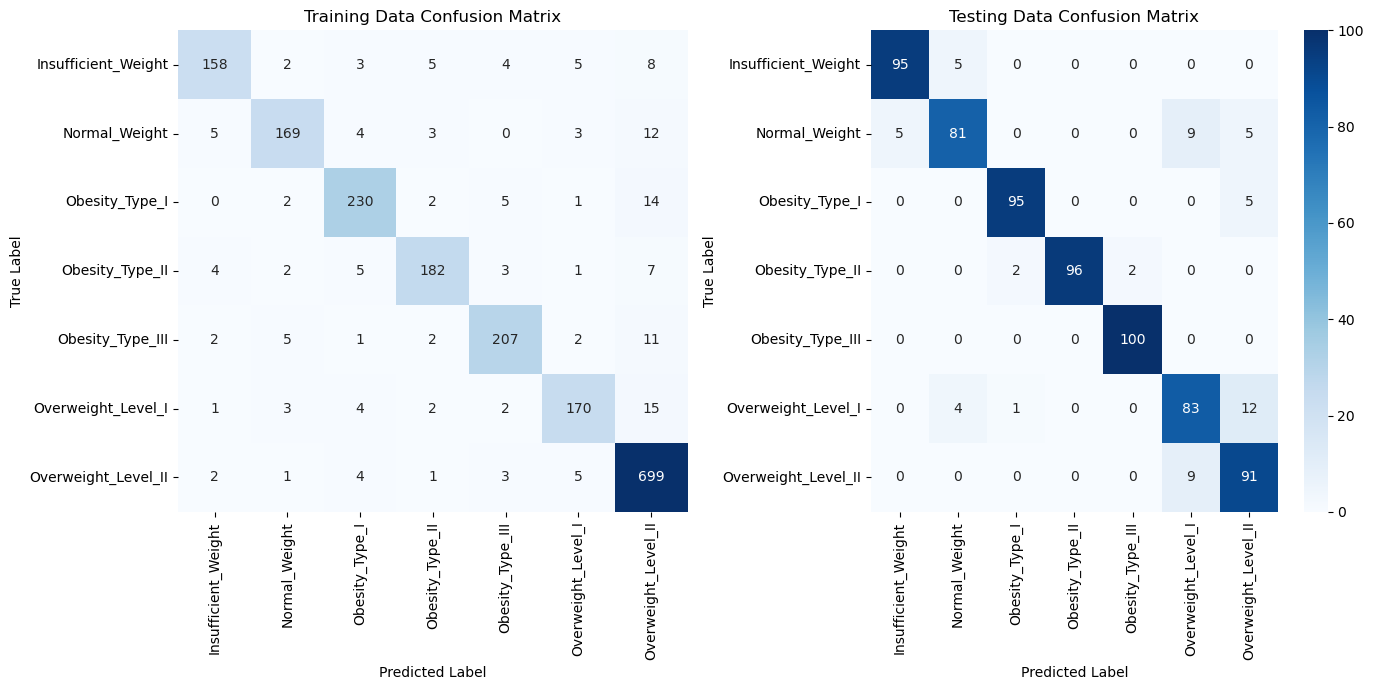

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Build the neural network model
model = Sequential()
model.add(InputLayer(input_shape=(X_train_transformed.shape[1],)))  # input layer dimensions must match features
for neurons in best_hyperparams[1:int(best_hyperparams[0]) + 1]:  # start from 1 because index 0 is the number of layers
    model.add(Dense(neurons, activation='relu'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))  # output layer dimensions must match the number of classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_transformed, y_train_encoded, epochs=10, batch_size=32, verbose=1)

# Making predictions for training and testing datasets
y_pred_train = np.argmax(model.predict(X_train_transformed), axis=1)
y_pred_test = np.argmax(model.predict(X_test_transformed), axis=1)

# Convert one-hot encoded labels back to single label
y_true_train = np.argmax(y_train_encoded, axis=1)
y_true_test = np.argmax(y_test_encoded, axis=1)

# Compute confusion matrices
cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_test = confusion_matrix(y_true_test, y_pred_test)

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Training confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', ax=axes[0], cmap='Blues', cbar=False)
axes[0].set_title('Training Data Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticklabels(class_labels, rotation=90)
axes[0].set_yticklabels(class_labels, rotation=0)

# Testing confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', ax=axes[1], cmap='Blues', cbar=True)
axes[1].set_title('Testing Data Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_xticklabels(class_labels, rotation=90)
axes[1].set_yticklabels(class_labels, rotation=0)

plt.tight_layout()
plt.show()

Starting Differential Evolution...
Individual 0: Fitness 0.8642857074737549 with structure [  2.90832497  23.         225.        ]
Individual 1: Fitness 0.9214285612106323 with structure [  4.76756469 498.         353.         462.         211.        ]
Individual 2: Fitness 0.8942857384681702 with structure [  3.54774759 148.          36.         134.        ]
Individual 3: Fitness 0.9128571152687073 with structure [  2.69251606 204.         404.        ]
Individual 4: Fitness 0.904285728931427 with structure [  2.35152984 404.          74.        ]
Individual 5: Fitness 0.9100000262260437 with structure [  3.20350937 497.         293.          18.        ]
Individual 6: Fitness 0.881428599357605 with structure [  4.0956981 474.        335.        416.        377.       ]
Individual 7: Fitness 0.8914285898208618 with structure [  2.48890792 208.         423.        ]
Individual 8: Fitness 0.8885714411735535 with structure [  4.15837312 195.         209.          27.         377.     

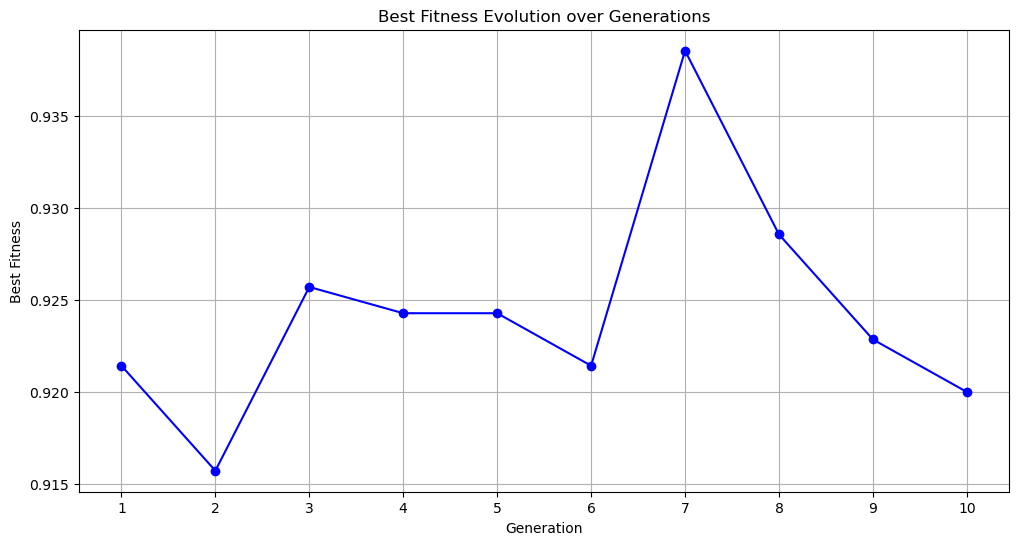

Total computational time: 862.74 seconds
Optimized architecture: 4 layers with neurons: [138.  12. 195. 404.]


In [18]:
# DE with probabilistic mutation optimizing both num of neurons and num of layers 0.2

def fitness_function(layer_structure):
    tf.keras.backend.clear_session()
    num_layers = int(layer_structure[0])
    neurons_per_layer = [int(neurons) for neurons in layer_structure[1:num_layers+1]]

    model = Sequential([InputLayer(input_shape=(X_train_transformed.shape[1],))])
    for neurons in neurons_per_layer:
        model.add(Dense(neurons, activation='relu'))
    model.add(Dense(y_train_encoded.shape[1], activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_transformed, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_test_transformed, y_test_encoded, verbose=0)
    return accuracy


def find_boundary_individual(population, a, bounds):
    a_norm = (a - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    pop_norm = (population - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])

    # Find the distance of each individual component to the nearest boundary (0 or 1 in normalized space)
    distance_to_boundary = np.minimum(pop_norm, 1 - pop_norm)
    # Sum the distances for each individual to get their total distance to the nearest boundary
    total_distance_to_boundary = np.sum(distance_to_boundary, axis=1)
    
    # Calculate the Euclidean distance from each individual to the reference individual 'a'
    distance_to_a = np.linalg.norm(pop_norm - a_norm, axis=1)

    # Combine the two distances
    combined_distance = total_distance_to_boundary + distance_to_a
    # Find the index of the individual with the minimum combined distance
    boundary_individual_idx = np.argmin(combined_distance)
    
    # Return the actual individual from the population
    return population[boundary_individual_idx]

def differential_evolution_modified_two(fitness_func, bounds, max_gen, pop_size, F=0.1, CR=0.7):
    start_time = time.time()
    print("Starting Differential Evolution...")
    pop = np.random.rand(pop_size, bounds.shape[0])
    pop_denorm = np.empty_like(pop)
    best_fitness_per_generation = []  # List to store the best fitness per generation

    # Initialize population within bounds and convert to the correct types
    for i in range(pop_size):
        pop_denorm[i, 0] = np.random.uniform(bounds[0, 0], bounds[0, 1])  # Number of layers as int
        for j in range(1, bounds.shape[0]):
            pop_denorm[i, j] = np.random.uniform(bounds[j, 0], bounds[j, 1])  # Neurons as int

    # Ensure that the number of neurons for unused layers is set to zero
    for individual in pop_denorm:
        num_layers = int(individual[0])
        individual[num_layers+1:] = 0
        individual[1:num_layers+1] = np.round(individual[1:num_layers+1]).astype(int)

    fitness = np.asarray([fitness_func(individual[:int(individual[0])+1]) for individual in pop_denorm])
    best_idx = np.argmax(fitness)
    best = pop_denorm[best_idx]

    for gen in range(max_gen):
        gen_best_fitness = -np.inf  # Initialize the best fitness for the current generation
        for i in range(pop_size):
            idxs = [idx for idx in range(pop_size) if idx != i]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]

            # Decide whether to use boundary individual in mutation
            if np.random.rand() < 0.2:
                boundary_individual = find_boundary_individual(pop, a, bounds)
                mutant = np.clip(a + F * (boundary_individual + b - c), 0, 1)
            else:
                mutant = np.clip(a + F * (b - c), 0, 1)

            cross_points = np.random.rand(bounds.shape[0]) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, bounds.shape[0])] = True

            trial = np.where(cross_points, mutant, pop[i])
            trial_denorm = trial.copy()
            trial_denorm[0] = np.random.uniform(bounds[0, 0], bounds[0, 1])
            for j in range(1, bounds.shape[0]):
                trial_denorm[j] = np.random.uniform(bounds[j, 0], bounds[j, 1])

            # Set neurons for unused layers to zero
            num_layers = int(trial_denorm[0])
            trial_denorm[num_layers+1:] = 0
            trial_denorm[1:num_layers+1] = np.round(trial_denorm[1:num_layers+1]).astype(int)

            f = fitness_func(trial_denorm[:num_layers+1])
            if f > fitness[i]:
                fitness[i] = f
                pop[i] = trial
                if f > gen_best_fitness:
                    gen_best_fitness = f
                if f > fitness[best_idx]:
                    best_idx = i
                    best = trial_denorm
            # Store the best fitness of the current generation
            print(f"Individual {i}: Fitness {fitness[i]} with structure {trial_denorm[:num_layers+1]}")
        best_fitness_per_generation.append(gen_best_fitness)
        print(f"Best fitness in generation {gen+1}: {gen_best_fitness}")

    print(f"Final best solution: {best[:int(best[0])+1]} with fitness {fitness[best_idx]}")

    # Plot the best fitness evolution after the loop
    plt.figure(figsize=(12, 6))
    plt.plot(best_fitness_per_generation, marker='o', linestyle='-', color='blue')
    plt.title('Best Fitness Evolution over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.grid(True)
    plt.xticks(range(max_gen), range(1, max_gen + 1))
    plt.show()
    
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f"Total computational time: {elapsed_time:.2f} seconds") 

    return best[:int(best[0])+1]


# Define the bounds for the number of layers and neurons per layer
max_layers = 5
bounds = np.array([[1, max_layers]])  # Bounds for the number of layers
for _ in range(max_layers):
    bounds = np.vstack([bounds, [5, 500]])  # Bounds for the number of neurons in each layer

# Run the Differential Evolution algorithm
best_hyperparams = differential_evolution_modified_two(fitness_function, bounds, max_gen=10, pop_size=100)

print(f"Optimized architecture: {int(best_hyperparams[0])} layers with neurons: {best_hyperparams[1:int(best_hyperparams[0])+1]}")

Epoch 1/10
62/62 [==============================] - 0s 735us/step - loss: 1.5205 - accuracy: 0.4498
Epoch 2/10
62/62 [==============================] - 0s 780us/step - loss: 0.9358 - accuracy: 0.7037
Epoch 3/10
62/62 [==============================] - 0s 802us/step - loss: 0.7227 - accuracy: 0.8072
Epoch 4/10
62/62 [==============================] - 0s 816us/step - loss: 0.6357 - accuracy: 0.8556
Epoch 5/10
62/62 [==============================] - 0s 928us/step - loss: 0.5859 - accuracy: 0.8602
Epoch 6/10
62/62 [==============================] - 0s 927us/step - loss: 0.5345 - accuracy: 0.8869
Epoch 7/10
62/62 [==============================] - 0s 978us/step - loss: 0.5128 - accuracy: 0.8884
Epoch 8/10
62/62 [==============================] - 0s 1ms/step - loss: 0.4842 - accuracy: 0.8965
Epoch 9/10
62/62 [==============================] - 0s 991us/step - loss: 0.4698 - accuracy: 0.8970
Epoch 10/10
22/22 [==============================] - 0s 462us/step


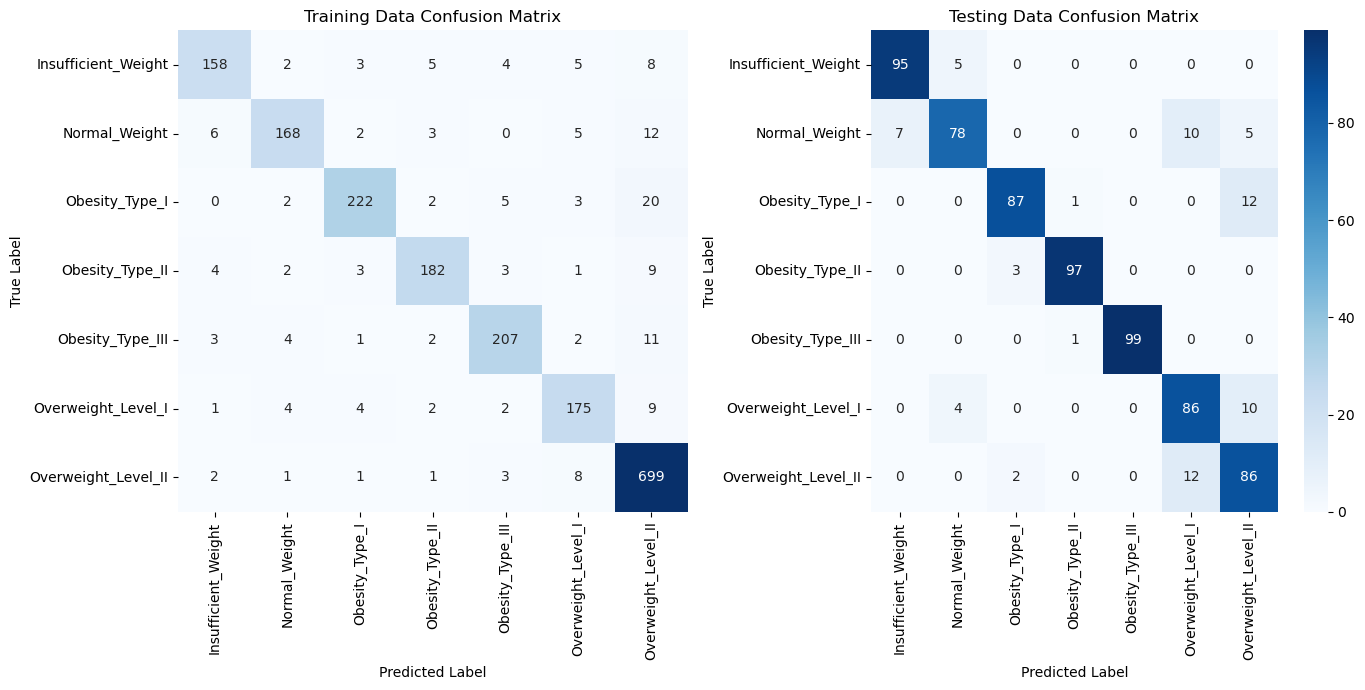

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Build the neural network model
model = Sequential()
model.add(InputLayer(input_shape=(X_train_transformed.shape[1],)))  # input layer dimensions must match features
for neurons in best_hyperparams[1:int(best_hyperparams[0]) + 1]:  # start from 1 because index 0 is the number of layers
    model.add(Dense(neurons, activation='relu'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))  # output layer dimensions must match the number of classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_transformed, y_train_encoded, epochs=10, batch_size=32, verbose=1)

# Making predictions for training and testing datasets
y_pred_train = np.argmax(model.predict(X_train_transformed), axis=1)
y_pred_test = np.argmax(model.predict(X_test_transformed), axis=1)

# Convert one-hot encoded labels back to single label
y_true_train = np.argmax(y_train_encoded, axis=1)
y_true_test = np.argmax(y_test_encoded, axis=1)

# Compute confusion matrices
cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_test = confusion_matrix(y_true_test, y_pred_test)

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Training confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', ax=axes[0], cmap='Blues', cbar=False)
axes[0].set_title('Training Data Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticklabels(class_labels, rotation=90)
axes[0].set_yticklabels(class_labels, rotation=0)

# Testing confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', ax=axes[1], cmap='Blues', cbar=True)
axes[1].set_title('Testing Data Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_xticklabels(class_labels, rotation=90)
axes[1].set_yticklabels(class_labels, rotation=0)

plt.tight_layout()
plt.show()

Starting Differential Evolution...
Individual 0: Fitness 0.8899999856948853 with structure [  2.43161102 220.         460.        ]
Individual 1: Fitness 0.881428599357605 with structure [  2.5836738 418.         60.       ]
Individual 2: Fitness 0.9142857193946838 with structure [  1.66632446 416.        ]
Individual 3: Fitness 0.8385714292526245 with structure [  1.43463698 444.        ]
Individual 4: Fitness 0.8971428275108337 with structure [  2.40127593 390.         372.        ]
Individual 5: Fitness 0.8857142925262451 with structure [  2.17773494  67.         217.        ]
Individual 6: Fitness 0.9142857193946838 with structure [  4.38360105 491.         250.         232.         276.        ]
Individual 7: Fitness 0.9114285707473755 with structure [  2.45387609  24.         223.        ]
Individual 8: Fitness 0.8928571343421936 with structure [  2.42210225 124.         225.        ]
Individual 9: Fitness 0.9028571248054504 with structure [  4.70804053 283.         483.         

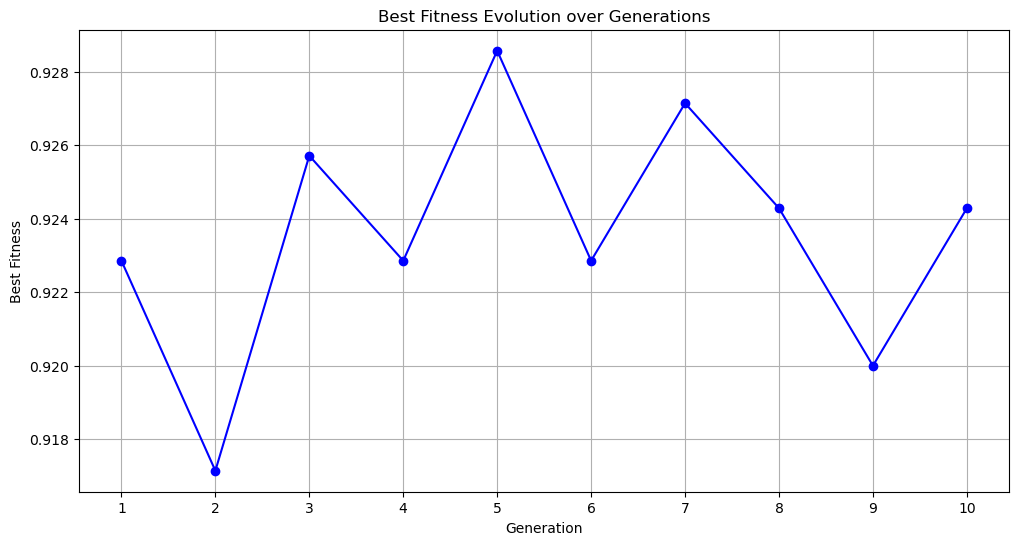

Total computational time: 13111.29 seconds
Optimized architecture: 4 layers with neurons: [387. 335. 107. 240.]


In [20]:
# DE with probabilistic mutation optimizing both num of neurons and num of layers 0.7

def fitness_function(layer_structure):
    tf.keras.backend.clear_session()
    num_layers = int(layer_structure[0])
    neurons_per_layer = [int(neurons) for neurons in layer_structure[1:num_layers+1]]

    model = Sequential([InputLayer(input_shape=(X_train_transformed.shape[1],))])
    for neurons in neurons_per_layer:
        model.add(Dense(neurons, activation='relu'))
    model.add(Dense(y_train_encoded.shape[1], activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_transformed, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_test_transformed, y_test_encoded, verbose=0)
    return accuracy


def find_boundary_individual(population, a, bounds):
    a_norm = (a - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    pop_norm = (population - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])

    # Find the distance of each individual component to the nearest boundary (0 or 1 in normalized space)
    distance_to_boundary = np.minimum(pop_norm, 1 - pop_norm)
    # Sum the distances for each individual to get their total distance to the nearest boundary
    total_distance_to_boundary = np.sum(distance_to_boundary, axis=1)
    
    # Calculate the Euclidean distance from each individual to the reference individual 'a'
    distance_to_a = np.linalg.norm(pop_norm - a_norm, axis=1)

    # Combine the two distances
    combined_distance = total_distance_to_boundary + distance_to_a
    # Find the index of the individual with the minimum combined distance
    boundary_individual_idx = np.argmin(combined_distance)
    
    # Return the actual individual from the population
    return population[boundary_individual_idx]

def differential_evolution_modified_seven(fitness_func, bounds, max_gen, pop_size, F=0.1, CR=0.7):
    start_time = time.time()
    print("Starting Differential Evolution...")
    pop = np.random.rand(pop_size, bounds.shape[0])
    pop_denorm = np.empty_like(pop)
    best_fitness_per_generation = []  # List to store the best fitness per generation

    # Initialize population within bounds and convert to the correct types
    for i in range(pop_size):
        pop_denorm[i, 0] = np.random.uniform(bounds[0, 0], bounds[0, 1])  # Number of layers as int
        for j in range(1, bounds.shape[0]):
            pop_denorm[i, j] = np.random.uniform(bounds[j, 0], bounds[j, 1])  # Neurons as int

    # Ensure that the number of neurons for unused layers is set to zero
    for individual in pop_denorm:
        num_layers = int(individual[0])
        individual[num_layers+1:] = 0
        individual[1:num_layers+1] = np.round(individual[1:num_layers+1]).astype(int)

    fitness = np.asarray([fitness_func(individual[:int(individual[0])+1]) for individual in pop_denorm])
    best_idx = np.argmax(fitness)
    best = pop_denorm[best_idx]

    for gen in range(max_gen):
        gen_best_fitness = -np.inf  # Initialize the best fitness for the current generation
        for i in range(pop_size):
            idxs = [idx for idx in range(pop_size) if idx != i]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]

            # Decide whether to use boundary individual in mutation
            if np.random.rand() < 0.7:
                boundary_individual = find_boundary_individual(pop, a, bounds)
                mutant = np.clip(a + F * (boundary_individual + b - c), 0, 1)
            else:
                mutant = np.clip(a + F * (b - c), 0, 1)

            cross_points = np.random.rand(bounds.shape[0]) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, bounds.shape[0])] = True

            trial = np.where(cross_points, mutant, pop[i])
            trial_denorm = trial.copy()
            trial_denorm[0] = np.random.uniform(bounds[0, 0], bounds[0, 1])
            for j in range(1, bounds.shape[0]):
                trial_denorm[j] = np.random.uniform(bounds[j, 0], bounds[j, 1])

            # Set neurons for unused layers to zero
            num_layers = int(trial_denorm[0])
            trial_denorm[num_layers+1:] = 0
            trial_denorm[1:num_layers+1] = np.round(trial_denorm[1:num_layers+1]).astype(int)

            f = fitness_func(trial_denorm[:num_layers+1])
            if f > fitness[i]:
                fitness[i] = f
                pop[i] = trial
                if f > gen_best_fitness:
                    gen_best_fitness = f
                if f > fitness[best_idx]:
                    best_idx = i
                    best = trial_denorm
            # Store the best fitness of the current generation
            print(f"Individual {i}: Fitness {fitness[i]} with structure {trial_denorm[:num_layers+1]}")
        best_fitness_per_generation.append(gen_best_fitness)
        print(f"Best fitness in generation {gen+1}: {gen_best_fitness}")

    print(f"Final best solution: {best[:int(best[0])+1]} with fitness {fitness[best_idx]}")

    # Plot the best fitness evolution after the loop
    plt.figure(figsize=(12, 6))
    plt.plot(best_fitness_per_generation, marker='o', linestyle='-', color='blue')
    plt.title('Best Fitness Evolution over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.grid(True)
    plt.xticks(range(max_gen), range(1, max_gen + 1))
    plt.show()
    
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f"Total computational time: {elapsed_time:.2f} seconds") 

    return best[:int(best[0])+1]


# Define the bounds for the number of layers and neurons per layer
max_layers = 5
bounds = np.array([[1, max_layers]])  # Bounds for the number of layers
for _ in range(max_layers):
    bounds = np.vstack([bounds, [5, 500]])  # Bounds for the number of neurons in each layer

# Run the Differential Evolution algorithm
best_hyperparams = differential_evolution_modified_seven(fitness_function, bounds, max_gen=10, pop_size=100)

print(f"Optimized architecture: {int(best_hyperparams[0])} layers with neurons: {best_hyperparams[1:int(best_hyperparams[0])+1]}")

Epoch 1/10
62/62 [==============================] - 0s 821us/step - loss: 1.2309 - accuracy: 0.5825
Epoch 2/10
62/62 [==============================] - 0s 762us/step - loss: 0.7134 - accuracy: 0.8188
Epoch 3/10
62/62 [==============================] - 0s 916us/step - loss: 0.6215 - accuracy: 0.8592
Epoch 4/10
62/62 [==============================] - 0s 918us/step - loss: 0.5499 - accuracy: 0.8708
Epoch 5/10
62/62 [==============================] - 0s 942us/step - loss: 0.5016 - accuracy: 0.8829
Epoch 6/10
62/62 [==============================] - 0s 925us/step - loss: 0.4786 - accuracy: 0.8930
Epoch 7/10
62/62 [==============================] - 0s 925us/step - loss: 0.4704 - accuracy: 0.8935
Epoch 8/10
62/62 [==============================] - 0s 932us/step - loss: 0.4408 - accuracy: 0.9026
Epoch 9/10
62/62 [==============================] - 0s 927us/step - loss: 0.4148 - accuracy: 0.9061
Epoch 10/10
22/22 [==============================] - 0s 711us/step


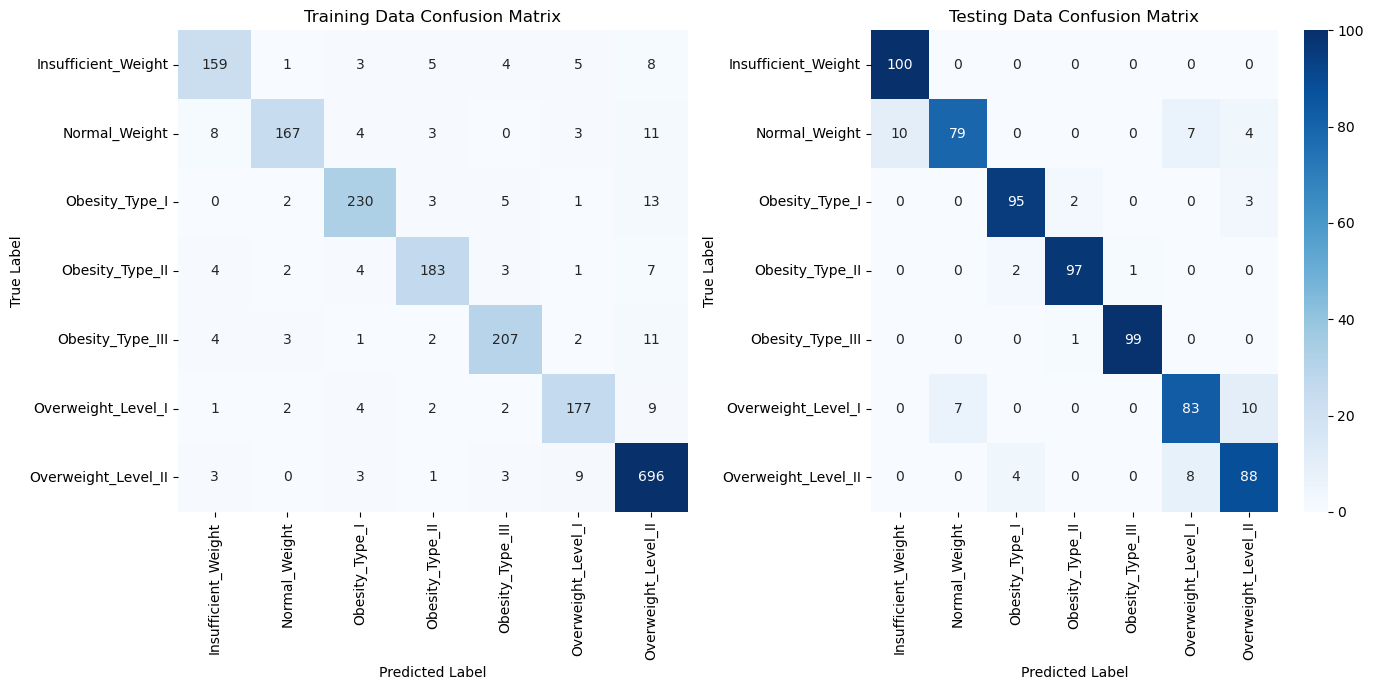

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Build the neural network model
model = Sequential()
model.add(InputLayer(input_shape=(X_train_transformed.shape[1],)))  # input layer dimensions must match features
for neurons in best_hyperparams[1:int(best_hyperparams[0]) + 1]:  # start from 1 because index 0 is the number of layers
    model.add(Dense(neurons, activation='relu'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))  # output layer dimensions must match the number of classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_transformed, y_train_encoded, epochs=10, batch_size=32, verbose=1)

# Making predictions for training and testing datasets
y_pred_train = np.argmax(model.predict(X_train_transformed), axis=1)
y_pred_test = np.argmax(model.predict(X_test_transformed), axis=1)

# Convert one-hot encoded labels back to single label
y_true_train = np.argmax(y_train_encoded, axis=1)
y_true_test = np.argmax(y_test_encoded, axis=1)

# Compute confusion matrices
cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_test = confusion_matrix(y_true_test, y_pred_test)

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Training confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', ax=axes[0], cmap='Blues', cbar=False)
axes[0].set_title('Training Data Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticklabels(class_labels, rotation=90)
axes[0].set_yticklabels(class_labels, rotation=0)

# Testing confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', ax=axes[1], cmap='Blues', cbar=True)
axes[1].set_title('Testing Data Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_xticklabels(class_labels, rotation=90)
axes[1].set_yticklabels(class_labels, rotation=0)

plt.tight_layout()
plt.show()

Starting Differential Evolution...
Individual 0: Fitness 0.8871428370475769 with structure [  2.88204167 455.         196.        ]
Individual 1: Fitness 0.8742856979370117 with structure [  1.3011178 212.       ]
Individual 2: Fitness 0.9071428775787354 with structure [  2.39144823 137.         220.        ]
Individual 3: Fitness 0.895714282989502 with structure [  3.71230709 106.         125.         285.        ]
Individual 4: Fitness 0.8885714411735535 with structure [  4.09017951  74.         458.         141.         434.        ]
Individual 5: Fitness 0.9071428775787354 with structure [  2.18723341 161.         432.        ]
Individual 6: Fitness 0.8885714411735535 with structure [  1.08854919 221.        ]
Individual 7: Fitness 0.904285728931427 with structure [  4.74001265 300.         104.         114.          45.        ]
Individual 8: Fitness 0.868571400642395 with structure [  2.32211966 427.          41.        ]
Individual 9: Fitness 0.8842856884002686 with structure [ 

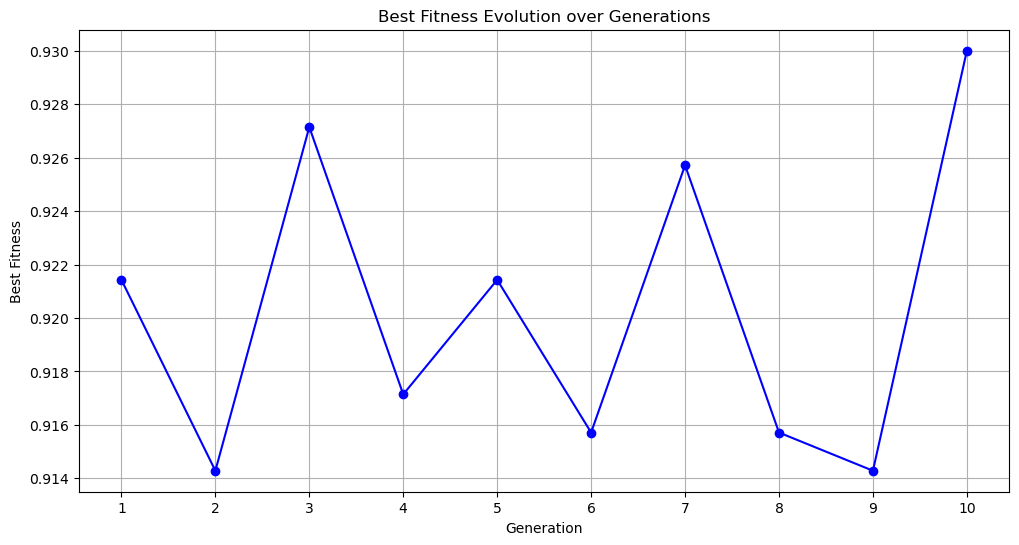

Total computational time: 27445.27 seconds
Optimized architecture: 4 layers with neurons: [383. 446. 154. 165.]


In [22]:
# DE with probabilistic mutation optimizing both num of neurons and num of layers 0.5

def fitness_function(layer_structure):
    tf.keras.backend.clear_session()
    num_layers = int(layer_structure[0])
    neurons_per_layer = [int(neurons) for neurons in layer_structure[1:num_layers+1]]

    model = Sequential([InputLayer(input_shape=(X_train_transformed.shape[1],))])
    for neurons in neurons_per_layer:
        model.add(Dense(neurons, activation='relu'))
    model.add(Dense(y_train_encoded.shape[1], activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_transformed, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_test_transformed, y_test_encoded, verbose=0)
    return accuracy


def find_boundary_individual_five(population, a, bounds):
    a_norm = (a - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    pop_norm = (population - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])

    # Find the distance of each individual component to the nearest boundary (0 or 1 in normalized space)
    distance_to_boundary = np.minimum(pop_norm, 1 - pop_norm)
    # Sum the distances for each individual to get their total distance to the nearest boundary
    total_distance_to_boundary = np.sum(distance_to_boundary, axis=1)
    
    # Calculate the Euclidean distance from each individual to the reference individual 'a'
    distance_to_a = np.linalg.norm(pop_norm - a_norm, axis=1)

    # Combine the two distances
    combined_distance = total_distance_to_boundary + distance_to_a
    # Find the index of the individual with the minimum combined distance
    boundary_individual_idx = np.argmin(combined_distance)
    
    # Return the actual individual from the population
    return population[boundary_individual_idx]

def differential_evolution_modified_five(fitness_func, bounds, max_gen, pop_size, F=0.1, CR=0.7):
    start_time = time.time()
    print("Starting Differential Evolution...")
    pop = np.random.rand(pop_size, bounds.shape[0])
    pop_denorm = np.empty_like(pop)
    best_fitness_per_generation = []  # List to store the best fitness per generation

    # Initialize population within bounds and convert to the correct types
    for i in range(pop_size):
        pop_denorm[i, 0] = np.random.uniform(bounds[0, 0], bounds[0, 1])  # Number of layers as int
        for j in range(1, bounds.shape[0]):
            pop_denorm[i, j] = np.random.uniform(bounds[j, 0], bounds[j, 1])  # Neurons as int

    # Ensure that the number of neurons for unused layers is set to zero
    for individual in pop_denorm:
        num_layers = int(individual[0])
        individual[num_layers+1:] = 0
        individual[1:num_layers+1] = np.round(individual[1:num_layers+1]).astype(int)

    fitness = np.asarray([fitness_func(individual[:int(individual[0])+1]) for individual in pop_denorm])
    best_idx = np.argmax(fitness)
    best = pop_denorm[best_idx]

    for gen in range(max_gen):
        gen_best_fitness = -np.inf  # Initialize the best fitness for the current generation
        for i in range(pop_size):
            idxs = [idx for idx in range(pop_size) if idx != i]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]

            # Decide whether to use boundary individual in mutation
            if np.random.rand() < 0.5:
                boundary_individual = find_boundary_individual(pop, a, bounds)
                mutant = np.clip(a + F * (boundary_individual + b - c), 0, 1)
            else:
                mutant = np.clip(a + F * (b - c), 0, 1)

            cross_points = np.random.rand(bounds.shape[0]) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, bounds.shape[0])] = True

            trial = np.where(cross_points, mutant, pop[i])
            trial_denorm = trial.copy()
            trial_denorm[0] = np.random.uniform(bounds[0, 0], bounds[0, 1])
            for j in range(1, bounds.shape[0]):
                trial_denorm[j] = np.random.uniform(bounds[j, 0], bounds[j, 1])

            # Set neurons for unused layers to zero
            num_layers = int(trial_denorm[0])
            trial_denorm[num_layers+1:] = 0
            trial_denorm[1:num_layers+1] = np.round(trial_denorm[1:num_layers+1]).astype(int)

            f = fitness_func(trial_denorm[:num_layers+1])
            if f > fitness[i]:
                fitness[i] = f
                pop[i] = trial
                if f > gen_best_fitness:
                    gen_best_fitness = f
                if f > fitness[best_idx]:
                    best_idx = i
                    best = trial_denorm
            # Store the best fitness of the current generation
            print(f"Individual {i}: Fitness {fitness[i]} with structure {trial_denorm[:num_layers+1]}")
        best_fitness_per_generation.append(gen_best_fitness)
        print(f"Best fitness in generation {gen+1}: {gen_best_fitness}")

    print(f"Final best solution: {best[:int(best[0])+1]} with fitness {fitness[best_idx]}")

    # Plot the best fitness evolution after the loop
    plt.figure(figsize=(12, 6))
    plt.plot(best_fitness_per_generation, marker='o', linestyle='-', color='blue')
    plt.title('Best Fitness Evolution over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.grid(True)
    plt.xticks(range(max_gen), range(1, max_gen + 1))
    plt.show()
    
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f"Total computational time: {elapsed_time:.2f} seconds") 

    return best[:int(best[0])+1]


# Define the bounds for the number of layers and neurons per layer
max_layers = 5
bounds = np.array([[1, max_layers]])  # Bounds for the number of layers
for _ in range(max_layers):
    bounds = np.vstack([bounds, [5, 500]])  # Bounds for the number of neurons in each layer

# Run the Differential Evolution algorithm
best_hyperparams = differential_evolution_modified_five(fitness_function, bounds, max_gen=10, pop_size=100)

print(f"Optimized architecture: {int(best_hyperparams[0])} layers with neurons: {best_hyperparams[1:int(best_hyperparams[0])+1]}")

Epoch 1/10
62/62 [==============================] - 0s 876us/step - loss: 1.2532 - accuracy: 0.5815
Epoch 2/10
62/62 [==============================] - 0s 961us/step - loss: 0.7380 - accuracy: 0.8127
Epoch 3/10
62/62 [==============================] - 0s 1ms/step - loss: 0.6068 - accuracy: 0.8632
Epoch 4/10
62/62 [==============================] - 0s 1ms/step - loss: 0.5524 - accuracy: 0.8728
Epoch 5/10
62/62 [==============================] - 0s 1ms/step - loss: 0.5067 - accuracy: 0.8829
Epoch 6/10
62/62 [==============================] - 0s 1ms/step - loss: 0.4617 - accuracy: 0.9006
Epoch 7/10
62/62 [==============================] - 0s 1ms/step - loss: 0.4494 - accuracy: 0.8970
Epoch 8/10
62/62 [==============================] - 0s 1ms/step - loss: 0.4278 - accuracy: 0.9046
Epoch 9/10
62/62 [==============================] - 0s 1ms/step - loss: 0.4136 - accuracy: 0.9016
Epoch 10/10
22/22 [==============================] - 0s 414us/step


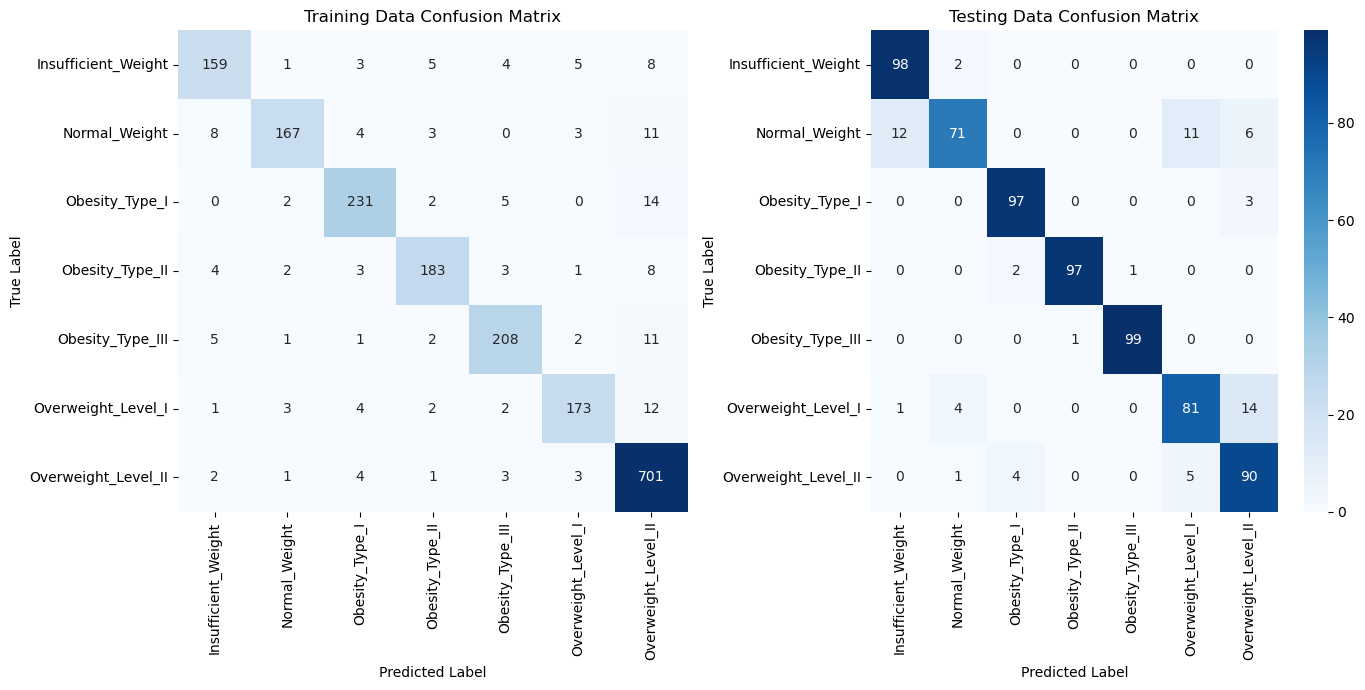

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Build the neural network model
model = Sequential()
model.add(InputLayer(input_shape=(X_train_transformed.shape[1],)))  # input layer dimensions must match features
for neurons in best_hyperparams[1:int(best_hyperparams[0]) + 1]:  # start from 1 because index 0 is the number of layers
    model.add(Dense(neurons, activation='relu'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))  # output layer dimensions must match the number of classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_transformed, y_train_encoded, epochs=10, batch_size=32, verbose=1)

# Making predictions for training and testing datasets
y_pred_train = np.argmax(model.predict(X_train_transformed), axis=1)
y_pred_test = np.argmax(model.predict(X_test_transformed), axis=1)

# Convert one-hot encoded labels back to single label
y_true_train = np.argmax(y_train_encoded, axis=1)
y_true_test = np.argmax(y_test_encoded, axis=1)

# Compute confusion matrices
cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_test = confusion_matrix(y_true_test, y_pred_test)

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Training confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', ax=axes[0], cmap='Blues', cbar=False)
axes[0].set_title('Training Data Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticklabels(class_labels, rotation=90)
axes[0].set_yticklabels(class_labels, rotation=0)

# Testing confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', ax=axes[1], cmap='Blues', cbar=True)
axes[1].set_title('Testing Data Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_xticklabels(class_labels, rotation=90)
axes[1].set_yticklabels(class_labels, rotation=0)

plt.tight_layout()
plt.show()

Starting Differential Evolution...
Individual 0: Fitness 0.8557142615318298 with structure [  2.50132363 431.         237.        ]
Individual 1: Fitness 0.7971428632736206 with structure [ 2.90742817 52.         20.        ]
Individual 2: Fitness 0.881428599357605 with structure [  2.00466652 341.          97.        ]
Individual 3: Fitness 0.895714282989502 with structure [  4.08045289  55.         169.         184.         439.        ]
Individual 4: Fitness 0.8842856884002686 with structure [  3.23899832 107.         236.         407.        ]
Individual 5: Fitness 0.9071428775787354 with structure [  3.72629827 214.         131.          85.        ]
Individual 6: Fitness 0.881428599357605 with structure [  1.01664465 107.        ]
Individual 7: Fitness 0.8928571343421936 with structure [  2.9833185 184.        367.       ]
Individual 8: Fitness 0.8842856884002686 with structure [  3.43001065 229.         495.          16.        ]
Individual 9: Fitness 0.7228571176528931 with str

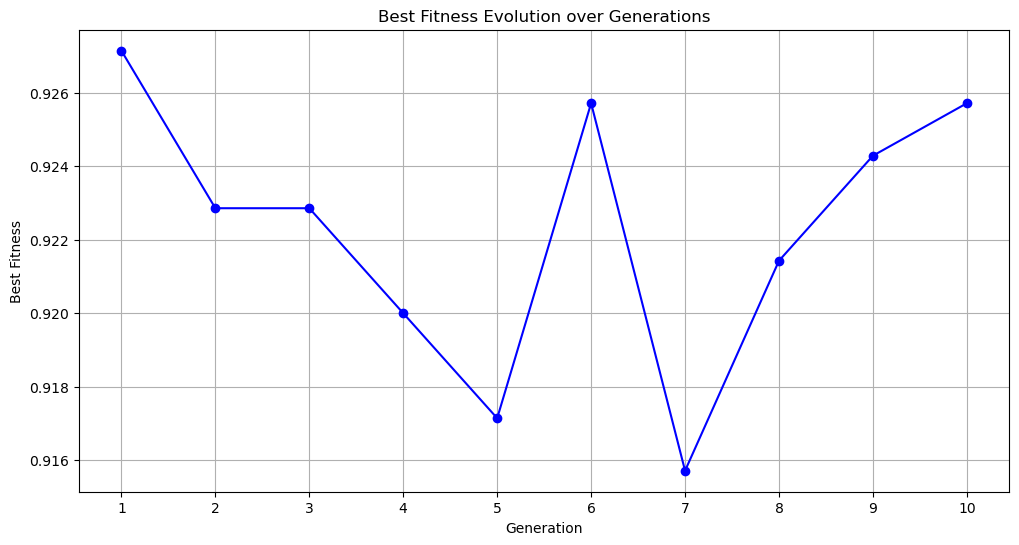

Optimized architecture: 4 layers with neurons: [261. 414. 291. 259.]


In [24]:
# DE with probabilistic mutation optimizing both num of neurons and num of layers 0.8

def fitness_function(layer_structure):
    tf.keras.backend.clear_session()
    num_layers = int(layer_structure[0])
    neurons_per_layer = [int(neurons) for neurons in layer_structure[1:num_layers+1]]

    model = Sequential([InputLayer(input_shape=(X_train_transformed.shape[1],))])
    for neurons in neurons_per_layer:
        model.add(Dense(neurons, activation='relu'))
    model.add(Dense(y_train_encoded.shape[1], activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_transformed, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_test_transformed, y_test_encoded, verbose=0)
    return accuracy


def find_boundary_individual_five(population, a, bounds):
    a_norm = (a - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    pop_norm = (population - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])

    # Find the distance of each individual component to the nearest boundary (0 or 1 in normalized space)
    distance_to_boundary = np.minimum(pop_norm, 1 - pop_norm)
    # Sum the distances for each individual to get their total distance to the nearest boundary
    total_distance_to_boundary = np.sum(distance_to_boundary, axis=1)
    
    # Calculate the Euclidean distance from each individual to the reference individual 'a'
    distance_to_a = np.linalg.norm(pop_norm - a_norm, axis=1)

    # Combine the two distances
    combined_distance = total_distance_to_boundary + distance_to_a
    # Find the index of the individual with the minimum combined distance
    boundary_individual_idx = np.argmin(combined_distance)
    
    # Return the actual individual from the population
    return population[boundary_individual_idx]

def differential_evolution_modified_eight(fitness_func, bounds, max_gen, pop_size, F=0.1, CR=0.7):
    start_time = time.time()
    print("Starting Differential Evolution...")
    pop = np.random.rand(pop_size, bounds.shape[0])
    pop_denorm = np.empty_like(pop)
    best_fitness_per_generation = []  # List to store the best fitness per generation

    # Initialize population within bounds and convert to the correct types
    for i in range(pop_size):
        pop_denorm[i, 0] = np.random.uniform(bounds[0, 0], bounds[0, 1])  # Number of layers as int
        for j in range(1, bounds.shape[0]):
            pop_denorm[i, j] = np.random.uniform(bounds[j, 0], bounds[j, 1])  # Neurons as int

    # Ensure that the number of neurons for unused layers is set to zero
    for individual in pop_denorm:
        num_layers = int(individual[0])
        individual[num_layers+1:] = 0
        individual[1:num_layers+1] = np.round(individual[1:num_layers+1]).astype(int)

    fitness = np.asarray([fitness_func(individual[:int(individual[0])+1]) for individual in pop_denorm])
    best_idx = np.argmax(fitness)
    best = pop_denorm[best_idx]

    for gen in range(max_gen):
        gen_best_fitness = -np.inf  # Initialize the best fitness for the current generation
        for i in range(pop_size):
            idxs = [idx for idx in range(pop_size) if idx != i]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]

            # Decide whether to use boundary individual in mutation
            if np.random.rand() < 0.8:
                boundary_individual = find_boundary_individual(pop, a, bounds)
                mutant = np.clip(a + F * (boundary_individual + b - c), 0, 1)
            else:
                mutant = np.clip(a + F * (b - c), 0, 1)

            cross_points = np.random.rand(bounds.shape[0]) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, bounds.shape[0])] = True

            trial = np.where(cross_points, mutant, pop[i])
            trial_denorm = trial.copy()
            trial_denorm[0] = np.random.uniform(bounds[0, 0], bounds[0, 1])
            for j in range(1, bounds.shape[0]):
                trial_denorm[j] = np.random.uniform(bounds[j, 0], bounds[j, 1])

            # Set neurons for unused layers to zero
            num_layers = int(trial_denorm[0])
            trial_denorm[num_layers+1:] = 0
            trial_denorm[1:num_layers+1] = np.round(trial_denorm[1:num_layers+1]).astype(int)

            f = fitness_func(trial_denorm[:num_layers+1])
            if f > fitness[i]:
                fitness[i] = f
                pop[i] = trial
                if f > gen_best_fitness:
                    gen_best_fitness = f
                if f > fitness[best_idx]:
                    best_idx = i
                    best = trial_denorm
            # Store the best fitness of the current generation
            print(f"Individual {i}: Fitness {fitness[i]} with structure {trial_denorm[:num_layers+1]}")
        best_fitness_per_generation.append(gen_best_fitness)
        print(f"Best fitness in generation {gen+1}: {gen_best_fitness}")

    print(f"Final best solution: {best[:int(best[0])+1]} with fitness {fitness[best_idx]}")

    # Plot the best fitness evolution after the loop
    plt.figure(figsize=(12, 6))
    plt.plot(best_fitness_per_generation, marker='o', linestyle='-', color='blue')
    plt.title('Best Fitness Evolution over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.grid(True)
    plt.xticks(range(max_gen), range(1, max_gen + 1))
    plt.show()

    return best[:int(best[0])+1]


# Define the bounds for the number of layers and neurons per layer
max_layers = 5
bounds = np.array([[1, max_layers]])  # Bounds for the number of layers
for _ in range(max_layers):
    bounds = np.vstack([bounds, [5, 500]])  # Bounds for the number of neurons in each layer

# Run the Differential Evolution algorithm
best_hyperparams = differential_evolution_modified_eight(fitness_function, bounds, max_gen=10, pop_size=100)

print(f"Optimized architecture: {int(best_hyperparams[0])} layers with neurons: {best_hyperparams[1:int(best_hyperparams[0])+1]}")

Epoch 1/10
62/62 [==============================] - 0s 1ms/step - loss: 1.1468 - accuracy: 0.6234
Epoch 2/10
62/62 [==============================] - 0s 1ms/step - loss: 0.7416 - accuracy: 0.8107
Epoch 3/10
62/62 [==============================] - 0s 1ms/step - loss: 0.5960 - accuracy: 0.8576
Epoch 4/10
62/62 [==============================] - 0s 1ms/step - loss: 0.5427 - accuracy: 0.8773
Epoch 5/10
62/62 [==============================] - 0s 1ms/step - loss: 0.5083 - accuracy: 0.8889
Epoch 6/10
62/62 [==============================] - 0s 1ms/step - loss: 0.4736 - accuracy: 0.8995
Epoch 7/10
62/62 [==============================] - 0s 1ms/step - loss: 0.4720 - accuracy: 0.8905
Epoch 8/10
62/62 [==============================] - 0s 1ms/step - loss: 0.4297 - accuracy: 0.8970
Epoch 9/10
62/62 [==============================] - 0s 1ms/step - loss: 0.4076 - accuracy: 0.9076
Epoch 10/10
22/22 [==============================] - 0s 463us/step


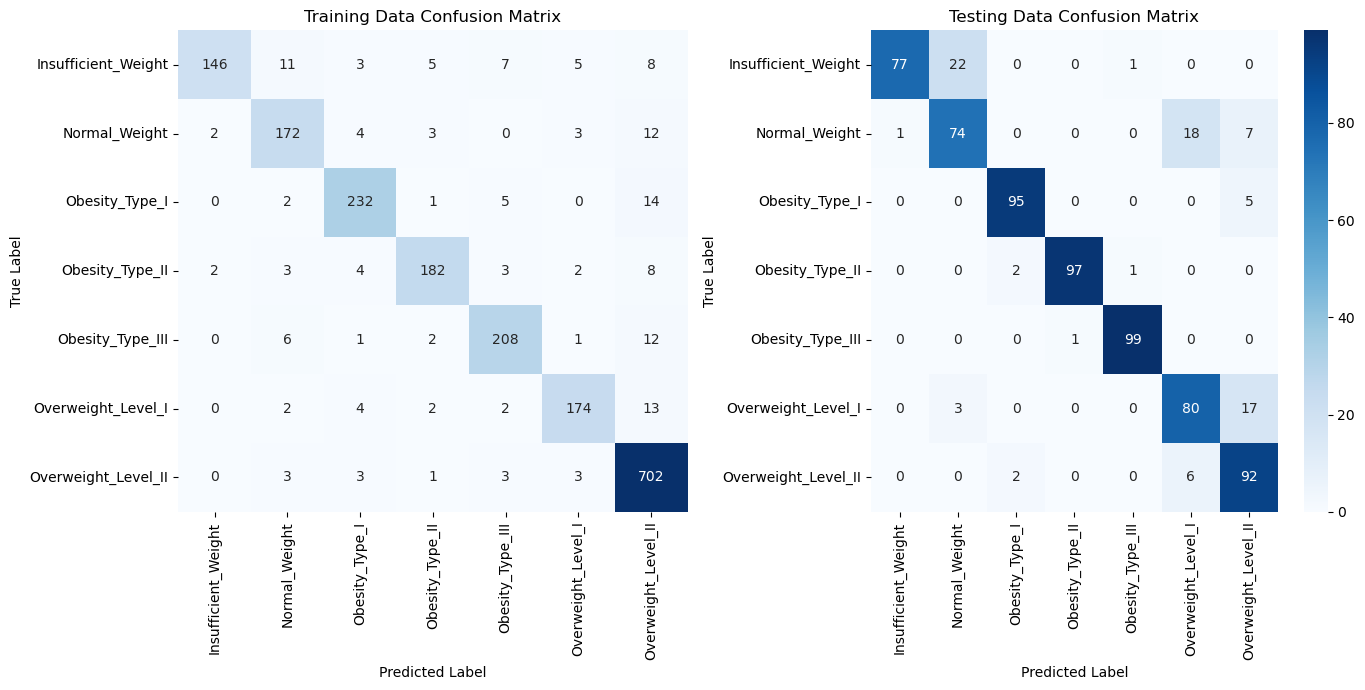

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Build the neural network model
model = Sequential()
model.add(InputLayer(input_shape=(X_train_transformed.shape[1],)))  # input layer dimensions must match features
for neurons in best_hyperparams[1:int(best_hyperparams[0]) + 1]:  # start from 1 because index 0 is the number of layers
    model.add(Dense(neurons, activation='relu'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))  # output layer dimensions must match the number of classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_transformed, y_train_encoded, epochs=10, batch_size=32, verbose=1)

# Making predictions for training and testing datasets
y_pred_train = np.argmax(model.predict(X_train_transformed), axis=1)
y_pred_test = np.argmax(model.predict(X_test_transformed), axis=1)

# Convert one-hot encoded labels back to single label
y_true_train = np.argmax(y_train_encoded, axis=1)
y_true_test = np.argmax(y_test_encoded, axis=1)

# Compute confusion matrices
cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_test = confusion_matrix(y_true_test, y_pred_test)

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Training confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', ax=axes[0], cmap='Blues', cbar=False)
axes[0].set_title('Training Data Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticklabels(class_labels, rotation=90)
axes[0].set_yticklabels(class_labels, rotation=0)

# Testing confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', ax=axes[1], cmap='Blues', cbar=True)
axes[1].set_title('Testing Data Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_xticklabels(class_labels, rotation=90)
axes[1].set_yticklabels(class_labels, rotation=0)

plt.tight_layout()
plt.show()